# WQD7003 : DATA ANALYTICS (Group Project)

## Flight Ticket Price Prediction

## Group 7


JOER YEOH (22077700)

MUHAMMAD SYAHIRUL KHALIQ BIN MOHAMED AIDI SHAHRIZ (22075208)

SAIDATUL HANIDA BINTI MOHD YUKHI (22082961)

VINOD KUNHI KRISHNAN ANNUKARAN (22079942)

IZZAH ATHIRAH BINTI MOHAMAD RADZI (S2179297)

# 1. Introduction

## 1.1 Project Background

## 1.2 Problem Statement

It’s really not easy to guess the price of a flight ticket. The price changes every hour/day/week/month and one person could get more expensive ticket now compared to other person buying the same ticket at a later time, and vice versa. 

To better understand how to actually estimate the price of a flight ticket, we have studied a dataset from the “EaseMyTrip” website that shows the booking history of passengers who travelled between India’s top six metro cities from February 11th to March 31st, 2022.


## 1.3 Project Objective

To analyze the flight booking dataset obtained from “EaseMyTrip” website to discover valuable insights that will be of great help to the passengers to get best ticket prices

# 2. Data Understanding

In this phase, the following steps were taken:
- **Initial Data Collection:** The dataset was downloaded from Kaggle Datasets. The dataset we have acquired comes in two parts, namely flights for economy class and business class. Here, we can load both parts of the dataset into two Pandas data frames by parsing the comma-separated values files.
- **Data Description**: A data dictionary providing detailed information about the variables and their attributes is constructed. It serves as a reference guide, enhancing data understanding and facilitating effective data management by disseminating essential metadata.
- **Data Quality Verification**: Identify missing values and assess opportunities for deriving new columns or removing irrelevant columns.

## 2.1 Initial Data Collection

The original dataset for the subsequent analyses originates from Kaggle Datasets. It is secondary data created from the EaseMyTrip website, an Indian online travel company based in Delhi. Specifically, the author used the Octoparse scraping tool to extract the data from the raw HTML strings. In addition, the dataset comes in two parts: one for economy class tickets and another for business class tickets. Both parts total 300,261 distinct flight booking options over 50 days, from February 11th to March 31st, 2022. The counts of flights are 206,774 and 93,487 for economy and business class, respectively.

The characteristics of the dataset are summarized below:
- Contains 300,000+ flight booking options from EaseMyTrip.
- In two parts: one for economy class tickets and another for business class tickets.
- Obtained from Kaggle Datasets.

## 2.2 Importing Libraries

The codes below are used to import various libraries and modules that will be used for our analysis.

1. `import json`: To provide functions for working with JSON data.

2. `import re`: To provide regular expression matching operations.

3. `import matplotlib.pyplot as plt`: To provide a MATLAB-like interface for creating visualizations.

4. `import numpy as np`: To provide support for large, multi-dimensional arrays and mathematical functions.

5. `import pandas as pd`: To provide data structures and functions for efficiently working with structured data, such as tabular data.

6. `import seaborn as sns`: To provide a high-level interface for creating visualization

7. `from sklearn.ensemble import RandomForestRegressor`: an ensemble machine learning model based on decision trees, used for regression tasks.

8. `from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor`: multiple linear regression models 

9. `from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score`: various evaluation metrics commonly used for evaluating regression models.

10. `from sklearn.model_selection import train_test_split`: To split a dataset into training and testing subsets for model evaluation.

11. `from sklearn.neighbors import KNeighborsRegressor`: a machine learning model that uses the k-nearest neighbors algorithm for regression tasks.

12. `from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler`: used for encoding categorical variables and scaling numerical features.

13. `%matplotlib inline`: This is a magic command used in Jupyter notebooks or IPython environments to display matplotlib plots directly in the notebook.

14. `%config InlineBackend.figure_formats = ['retina']`: This sets the configuration for the figure formats in the notebook, specifying that the 'retina' format should be used for better quality plots on high-resolution displays.


In [1]:
import json
import re

from catboost import CatBoostRegressor
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from lightgbm import log_evaluation, LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor, plot_importance

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

## 2.3 Data Loading

As the dataset comes in two CSV files, we read the contents and loaded them into two separate data frames, namely, `df_eco` and `df_biz`.

In [2]:
df_eco = pd.read_csv("dataset/economy.csv", thousands=',')
df_biz = pd.read_csv("dataset/business.csv", thousands=',')

Then, we displayed the top few rows of the data frames to inspect the structure and content of the data, including column names and a preview of data values, allowing us to glimpse the data and assess its quality, format, and initial patterns.

In [3]:
df_eco_disp = df_eco.copy()
df_biz_disp = df_biz.copy()
df_eco_disp.stop = df_eco_disp.stop.str.slice(0, 8)
df_biz_disp.stop = df_biz_disp.stop.str.slice(0, 8)

pd.concat((df_eco.head(), df_biz_disp.head()))

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,5953
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,5953
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,5956
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,5955
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,5955
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,25612
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,25612
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t,20:45,Mumbai,42220
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t,23:55,Mumbai,44450
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t,23:55,Mumbai,46690


## 2.4 Data Description

There are 11 columns in this flight ticket price prediction dataset, which includes airlines, source city, departure and arrival time, destination, etc. The various features of the raw dataset are explained below:

- `date`: The booking date consists of the day, month, and year components, providing a complete representation of when the booking was made.
- `airline`: The airline column in the dataset contains the names of airline companies. This categorical feature encompasses a total of six different airlines.
- `ch_code`: The "ch_code" represents a character-based flight code, typically consisting of alphabetic characters. This code may include letters corresponding to the airline, airport, or specific flight route.
- `num_code`: The "num_code" refers to a numerical flight code, typically composed of numeric digits. This code is usually assigned sequentially or based on certain conventions and may not carry any specific meaning. It is commonly used for internal tracking or system purposes.
- `dep_time`: The departure time represents when an aircraft is expected to take off and begin its journey to the destination. Departure time is typically specified using a 24-hour clock format, indicating hours and minutes.
- `from`: The departure city refers to the specific city from which a flight originates or takes off. It is a categorical feature with six unique cities.
- `time_taken`: A continuous feature that represents the total time taken to travel between cities, expressed in hours and minutes.
- `stop`: A categorical feature with three unique values representing the number of stops between the source and destination cities.
- `arr_time`: Arrival time refers to the specific time at which a flight is scheduled to arrive at its destination airport. It indicates the estimated time of arrival (ETA) when the aircraft is expected to land and complete its journey. Arrival time is typically specified using a 24-hour clock format, indicating hours and minutes.
- `to`: The arrival city refers to the specific city where a flight is scheduled to land or arrive. It is a categorical feature with six unique cities.
- `price`: The target variable contains information about the ticket price. It serves as the dependent variable or the outcome variable that is being predicted or analyzed in a machine learning or statistical model.


## 2.5 Data Quality Verification

The summary of the data frame displays useful information such as the number of rows and columns, the data types of each column, the count of non-null values, and memory usage.

In [4]:
df_eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        206774 non-null  object
 1   airline     206774 non-null  object
 2   ch_code     206774 non-null  object
 3   num_code    206774 non-null  int64 
 4   dep_time    206774 non-null  object
 5   from        206774 non-null  object
 6   time_taken  206774 non-null  object
 7   stop        206774 non-null  object
 8   arr_time    206774 non-null  object
 9   to          206774 non-null  object
 10  price       206774 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 17.4+ MB


In [5]:
df_biz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        93487 non-null  object
 1   airline     93487 non-null  object
 2   ch_code     93487 non-null  object
 3   num_code    93487 non-null  int64 
 4   dep_time    93487 non-null  object
 5   from        93487 non-null  object
 6   time_taken  93487 non-null  object
 7   stop        93487 non-null  object
 8   arr_time    93487 non-null  object
 9   to          93487 non-null  object
 10  price       93487 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 7.8+ MB


Following the summaries, there were no missing values, as the count of non-null values is identical to the length of the data frames. Subsequently, we identified the unique values in the selected columns and inconsistent categories by finding unexpected or irregular values from the unique values.

In [6]:
categorical_columns = ["airline", "ch_code", "from", "to"]
categorical_dict_eco = {}
categorical_dict_biz = {}

for column in categorical_columns:
  categorical_dict_eco[column] = df_eco[column].unique()
  categorical_dict_biz[column] = df_biz[column].unique()

print("Economy Class")
display(pd.DataFrame.from_dict(categorical_dict_eco, orient="index"))
print(df_eco["stop"].unique()[:5])

print("\n", "Business Class")
display(pd.DataFrame.from_dict(categorical_dict_biz, orient="index"))
print(df_biz["stop"].unique()[:5])

Economy Class


,0,1,2,3,4,5,6,7
airline,SpiceJet,AirAsia,Vistara,GO FIRST,Indigo,Air India,Trujet,StarAir
ch_code,SG,I5,UK,G8,6E,AI,2T,S5
from,Delhi,Mumbai,Bangalore,Kolkata,Hyderabad,Chennai,None,None
to,Mumbai,Bangalore,Kolkata,Hyderabad,Chennai,Delhi,None,None


['non-stop ' '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Chennai\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Indore\n\t\t\t\t\t\t\t\t\t\t\t\t']

 Business Class


,0,1,2,3,4,5
airline,Air India,Vistara,None,None,None,None
ch_code,AI,UK,None,None,None,None
from,Delhi,Mumbai,Bangalore,Kolkata,Hyderabad,Chennai
to,Mumbai,Bangalore,Kolkata,Hyderabad,Chennai,Delhi


['non-stop ' '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Chennai\n\t\t\t\t\t\t\t\t\t\t\t\t']


Based on the displayed outputs, it is evident that the "stop" column contains inconsistent data characterized by the presence of control characters, such as newline and tab characters, within the words. Next, we identified and displayed the duplicated rows in the data frame. We will remove the duplicated rows in the next phase.

In [7]:
df_eco_duplicated = df_eco.duplicated(keep=False)
df_biz_duplicated = df_biz.duplicated(keep=False)

print(f"Number of duplicated rows (Economy Class): {np.sum(df_eco_duplicated) // 2}")
print(f"Number of duplicated rows (Business Class): {np.sum(df_biz_duplicated) // 2}")

df_eco_disp[df_eco_duplicated == True]

Number of duplicated rows (Economy Class): 2
Number of duplicated rows (Business Class): 0


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
516,14-02-2022,Air India,AI,807,17:20,Delhi,15h 15m,1-stop\n\t,08:35,Mumbai,12150
563,14-02-2022,Air India,AI,807,17:20,Delhi,15h 15m,1-stop\n\t,08:35,Mumbai,12150
6080,13-03-2022,Air India,AI,475,13:00,Delhi,24h 35m,1-stop\n\t,13:35,Mumbai,4780
6181,13-03-2022,Air India,AI,475,13:00,Delhi,24h 35m,1-stop\n\t,13:35,Mumbai,4780


# 3. Data Preprocessing

## 3.1 Data Selection

We can begin by computing the Pearson correlation coefficients between the numerical features. If the correlations between variables are too strong that another variable does not convey extra information, we can remove them. In our case, the evaluation will happen during the Exploratory Data Analysis.

## 3.2 Data Cleaning

In [127]:
def deduplicate(df):
  df.drop_duplicates(inplace=True)

Renamed some columns so that they would be more descriptive and easier to understand:

In [8]:
def rename_columns(df):
    df.rename(
        columns={
            "from": "source_city",
            "to": "destination_city",
            "dep_time": "departure_time",
            "arr_time": "arrival_time"
        },
        inplace=True
    )

Created a new feature called "days_left" to see how many days are remaining until booking date:

In [9]:
def create_days_left_feature(df):
    df.date = pd.to_datetime(df.date, format="%d-%m-%Y")
    booking_date = df.date.min() - pd.Timedelta(days=1)

    df["days_left"] = (df.date - booking_date).dt.days

Created a new feature called "flight" by concatenating two existing columns which are 'ch_code' and 'num_code' from 'df_eco' DataFrame:

In [10]:
def create_flight_feature(df):
    df["flight"] = df_eco.ch_code + "-" + df_eco.num_code.astype(str)

    return df

Created a new column by splitting the "departure_time" column into separate hour and minute components:

In [11]:
def create_departure_feature(df):
    cols = ["departure_time_hr", "departure_time_min"]

    df[cols] = df.departure_time.str.split(":", expand=True)
    df[cols] = df[cols].astype(np.int64)

Created a new column by splitting the "arrival_time" column into separate hour and minute components:

In [12]:
def create_arrival_feature(df):
    cols = ["arrival_time_hr", "arrival_time_min"]

    df[cols] = df.arrival_time.str.split(":", expand=True)
    df[cols] = df[cols].astype(np.int64)

Created a new feature called "duration" by extracting hour and minute components from the "time_taken" column and calculate the total duration in minutes:

In [13]:
def create_duration_feature(df):
    def transform_time_taken(item):
        hour, minute = re.search("([\d.]*)h ([\d.]*)m", item).groups()

        return float(minute or 0) + float(hour or 0) * 60

    df["duration"] = df.time_taken.apply(transform_time_taken)

Created two new features, namely "stops" and "via", based on the values in the existing "stop" column:

In [14]:
def create_via_feature(df):
    stops = []
    via_list = []

    for item in df.stop:
        item = re.sub("[\n\t]+", " ", item)
        stop, via = re.search("([\w+-]+)(?: Via (\w+))?", item).groups()

        if not via:
            via = "UNK"

        stops.append(stop)
        via_list.append(via)

    df["stops"] = pd.Series(stops)
    df["via"] = pd.Series(via_list)

Added a new column called "class" and assigns it the value provided by the 'class_' variable:

In [15]:
def create_class_feature(df, class_):
    df["class"] = class_

Performed a series of data transformations on the 'df_eco' DataFrame and stores the modified DataFrame in 'df_eco_t': 

In [130]:
df_eco_t = df_eco.copy()

deduplicate(df_eco_t)
rename_columns(df_eco_t)
create_days_left_feature(df_eco_t)
create_flight_feature(df_eco_t)
create_departure_feature(df_eco_t)
create_arrival_feature(df_eco_t)
create_duration_feature(df_eco_t)
create_via_feature(df_eco_t)
create_class_feature(df_eco_t, "Economy")

df_eco_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206772 entries, 0 to 206773
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                206772 non-null  datetime64[ns]
 1   airline             206772 non-null  object        
 2   ch_code             206772 non-null  object        
 3   num_code            206772 non-null  int64         
 4   departure_time      206772 non-null  object        
 5   source_city         206772 non-null  object        
 6   time_taken          206772 non-null  object        
 7   stop                206772 non-null  object        
 8   arrival_time        206772 non-null  object        
 9   destination_city    206772 non-null  object        
 10  price               206772 non-null  int64         
 11  days_left           206772 non-null  int64         
 12  flight              206772 non-null  object        
 13  departure_time_hr   206772 non-nul

Performed a series of data transformations on the 'df_biz' DataFrame and stores the modified DataFrame in 'df_biz_t':

In [17]:
df_biz_t = df_biz.copy()

rename_columns(df_biz_t)
create_days_left_feature(df_biz_t)
create_flight_feature(df_biz_t)
create_departure_feature(df_biz_t)
create_arrival_feature(df_biz_t)
create_duration_feature(df_biz_t)
create_via_feature(df_biz_t)
create_class_feature(df_biz_t, "Business")

df_biz_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                93487 non-null  datetime64[ns]
 1   airline             93487 non-null  object        
 2   ch_code             93487 non-null  object        
 3   num_code            93487 non-null  int64         
 4   departure_time      93487 non-null  object        
 5   source_city         93487 non-null  object        
 6   time_taken          93487 non-null  object        
 7   stop                93487 non-null  object        
 8   arrival_time        93487 non-null  object        
 9   destination_city    93487 non-null  object        
 10  price               93487 non-null  int64         
 11  days_left           93487 non-null  int64         
 12  flight              93487 non-null  object        
 13  departure_time_hr   93487 non-null  int64     

## 3.3 Data Integration

Concatenated two DataFrames, 'df_eco_t' and 'df_biz_t', into a single DataFrame called df:

In [18]:
df = pd.concat([df_eco_t, df_biz_t])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300261 entries, 0 to 93486
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                300261 non-null  datetime64[ns]
 1   airline             300261 non-null  object        
 2   ch_code             300261 non-null  object        
 3   num_code            300261 non-null  int64         
 4   departure_time      300261 non-null  object        
 5   source_city         300261 non-null  object        
 6   time_taken          300261 non-null  object        
 7   stop                300261 non-null  object        
 8   arrival_time        300261 non-null  object        
 9   destination_city    300261 non-null  object        
 10  price               300261 non-null  int64         
 11  days_left           300261 non-null  int64         
 12  flight              300261 non-null  object        
 13  departure_time_hr   300261 non-null

## 3.4 Data Formatting

Training and Testing of Data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != target],
    df[target]
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [30]:
print(X_train.shape)
print(y_train.shape)
print()

print(X_val.shape)
print(y_val.shape)
print()

print(X_test.shape)
print(y_test.shape)

(202675, 20)
(202675,)

(22520, 20)
(22520,)

(75066, 20)
(75066,)


Transformed the categorical features in the training, validation, and test datasets into numerical values:

In [31]:
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train_cat = oe.fit_transform(X_train[categorical_features])
X_val_cat = oe.transform(X_val[categorical_features])
X_test_cat = oe.transform(X_test[categorical_features])

Combined categorical and numerical features column-wise:

In [32]:
X_train_mat = np.hstack((X_train_cat, X_train[numerical_features]))
X_val_mat = np.hstack((X_val_cat, X_val[numerical_features]))
X_test_mat = np.hstack((X_test_cat, X_test[numerical_features]))

In [33]:
mm = MinMaxScaler()

X_train_scaled = mm.fit_transform(X_train_mat)
X_val_scaled = mm.transform(X_val_mat)
X_test_scaled = mm.transform(X_test_mat)

y_train_scaled = np.log1p(y_train)
y_val_scaled = np.log1p(y_val)
y_test_scaled = np.log1p(y_test)

# 4. Exploratory Data Analysis (EDA)

We created a pie chart visualization to see the distribution of different classes ("Economy" and "Business") in the "class" column:

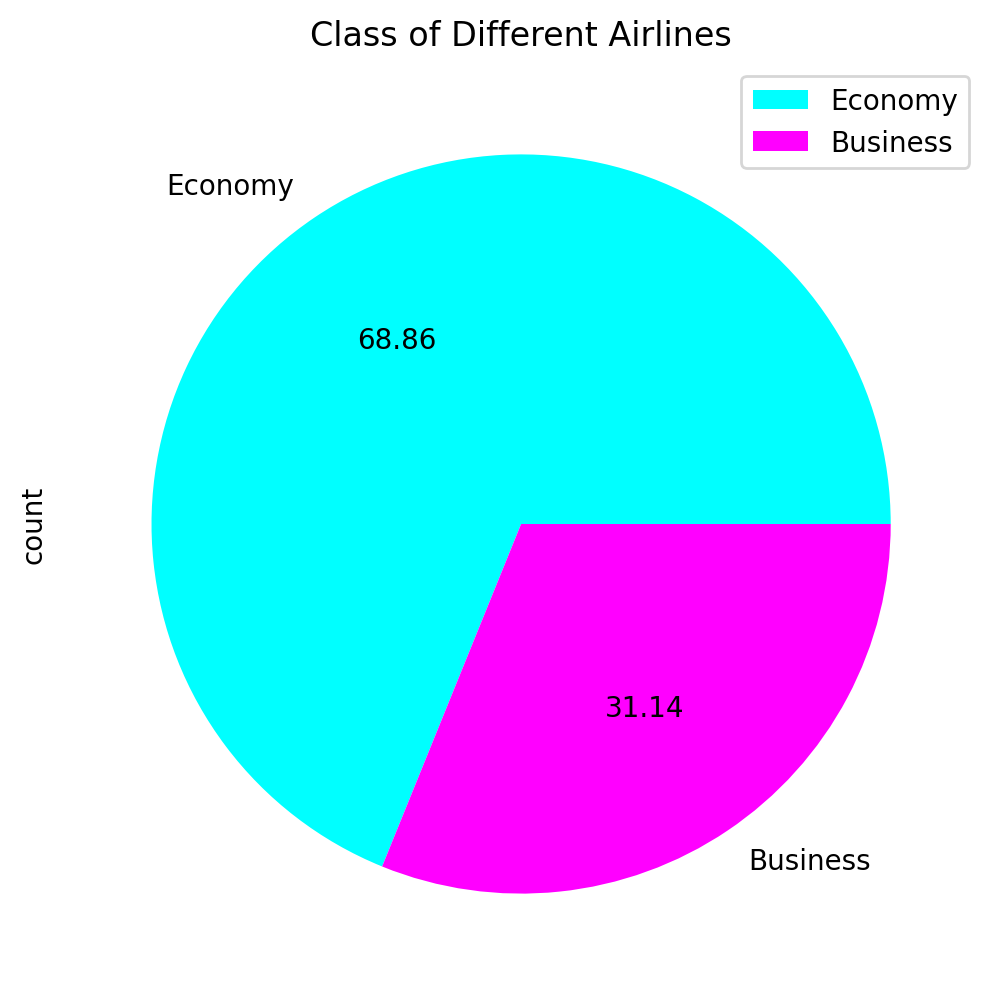

In [19]:
plt.figure(figsize =(8,6))
df["class"].value_counts().plot(kind ='pie', textprops ={'color':'black'}, cmap='cool', autopct ='%.2f')
plt.legend(['Economy','Business'])
plt.title("Class of Different Airlines")
plt.show()

Created a grouped bar chart to provide insights into the distribution of classes across different airlines through cross-tabulation:

class      Business  Economy
airline                     
Air India     32898    47996
AirAsia           0    16098
GO FIRST          0    23177
Indigo            0    43120
SpiceJet          0     9011
StarAir           0       61
Trujet            0       41
Vistara       60589    67270


<Axes: xlabel='airline'>

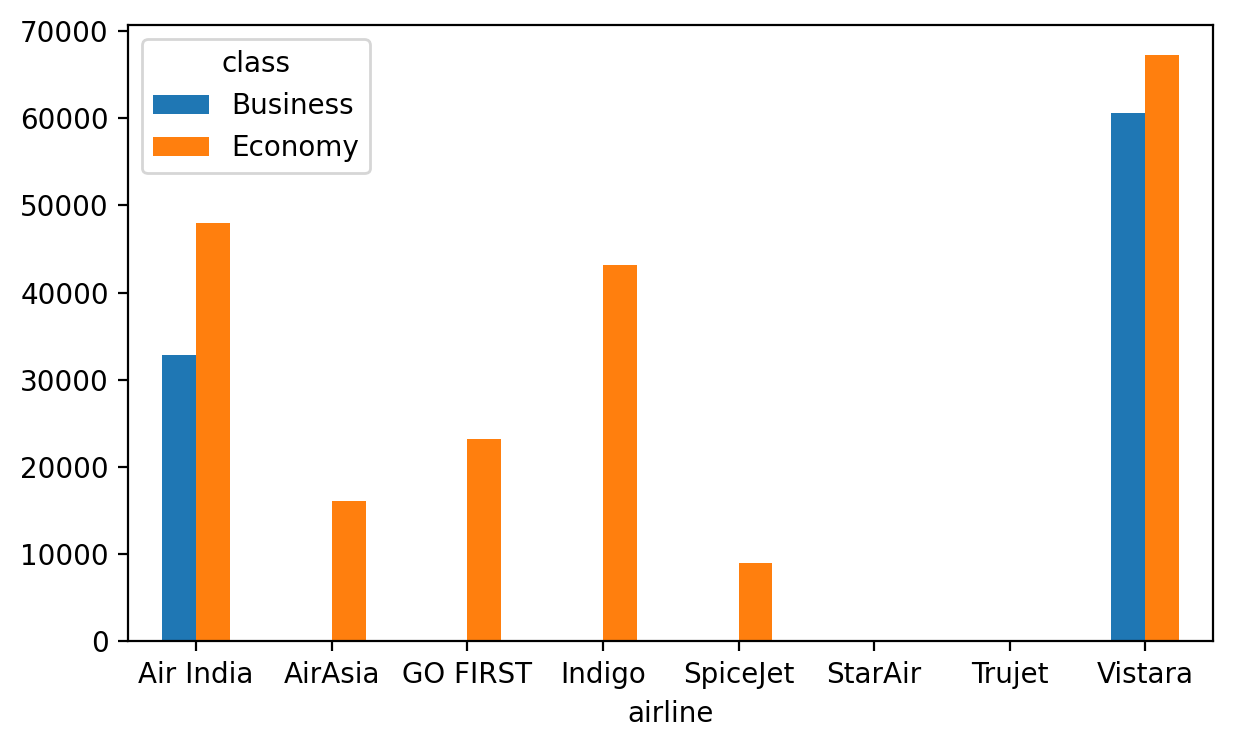

In [20]:
# Cross tabulation between airline and class
CrosstabResult=pd.crosstab(index=df['airline'],columns=df['class'])
print(CrosstabResult)
 
# Grouped bar chart between airline and class
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

Visualized the pricing data in boxplot to see the price distribution by each airline:

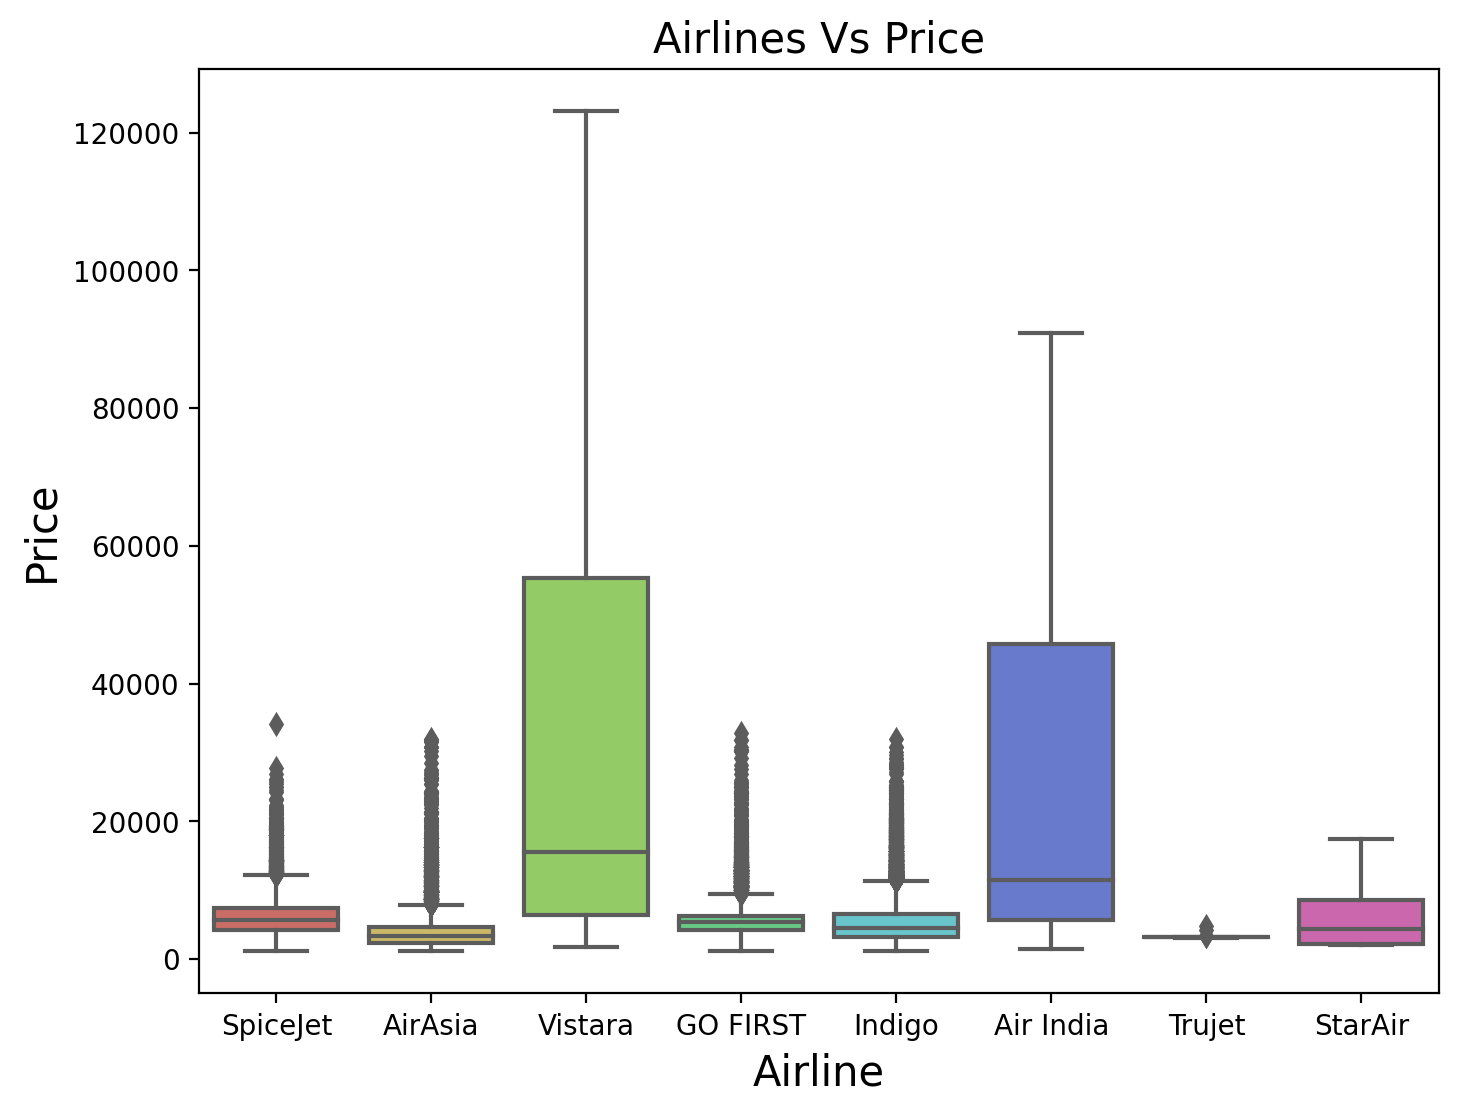

In [21]:
plt.figure(figsize =(8,6))
sns.boxplot(x=df['airline'], y= df['price'],palette='hls')
plt.title("Airlines Vs Price", fontsize=15)
plt.xlabel("Airline", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.show()

Visualized the cross-tabulation between two variables, "class" and "destination_city" in a grouped bar chart: 

destination_city  Bangalore  Chennai  Delhi  Hyderabad  Kolkata  Mumbai
class                                                                  
Business              16198    13158  16707      13675    14758   18991
Economy               34914    27210  40654      29101    34777   40118


<Axes: xlabel='class'>

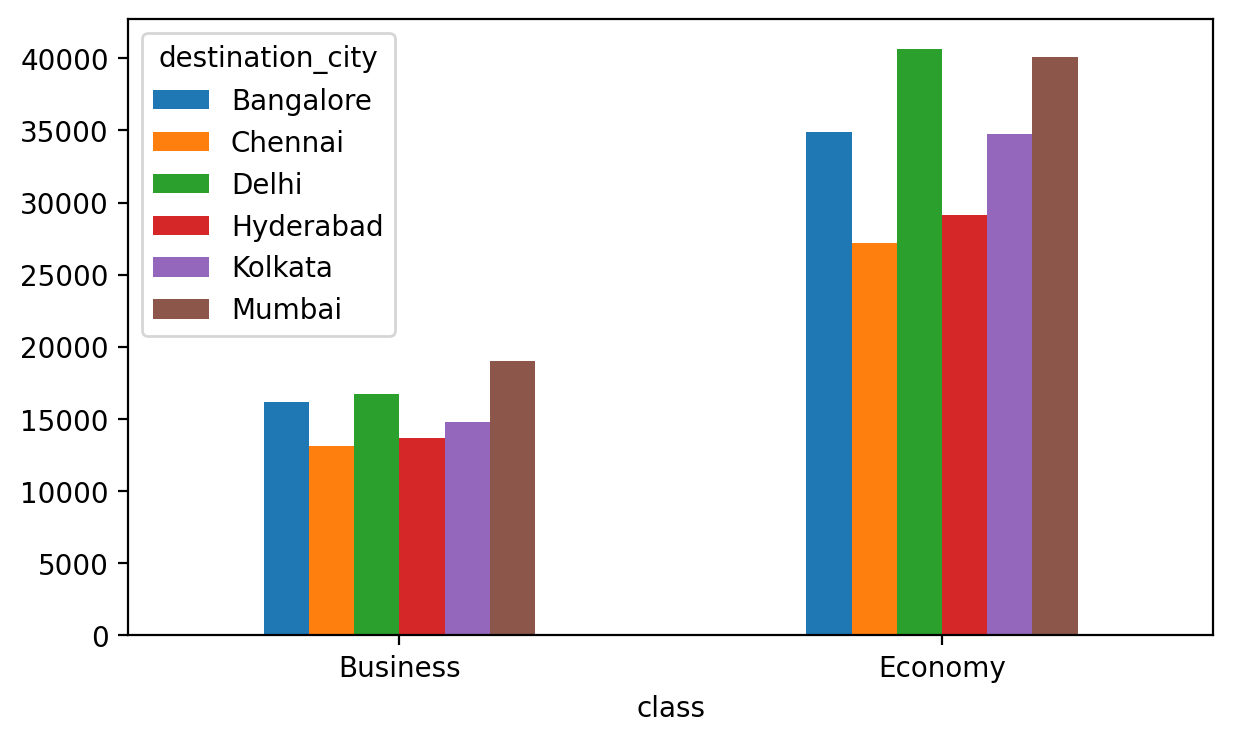

In [22]:
# Cross tabulation between class and destination
CrosstabResult=pd.crosstab(index=df['class'],columns=df['destination_city'])
print(CrosstabResult)
 
# Grouped bar chart between class and destination
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

Created a DataFrame called 'destination' to see frequency of each destination city in the "destination_city" column:

In [23]:
destination= pd.DataFrame({'destination_city':df.destination_city.value_counts().index,'Counts':df.destination_city.value_counts()})
destination

,destination_city,Counts
destination_city,,
Mumbai,Mumbai,59109
Delhi,Delhi,57361
Bangalore,Bangalore,51112
Kolkata,Kolkata,49535
Hyderabad,Hyderabad,42776
Chennai,Chennai,40368


Plotted a bar chart to see the counts of each destination city:

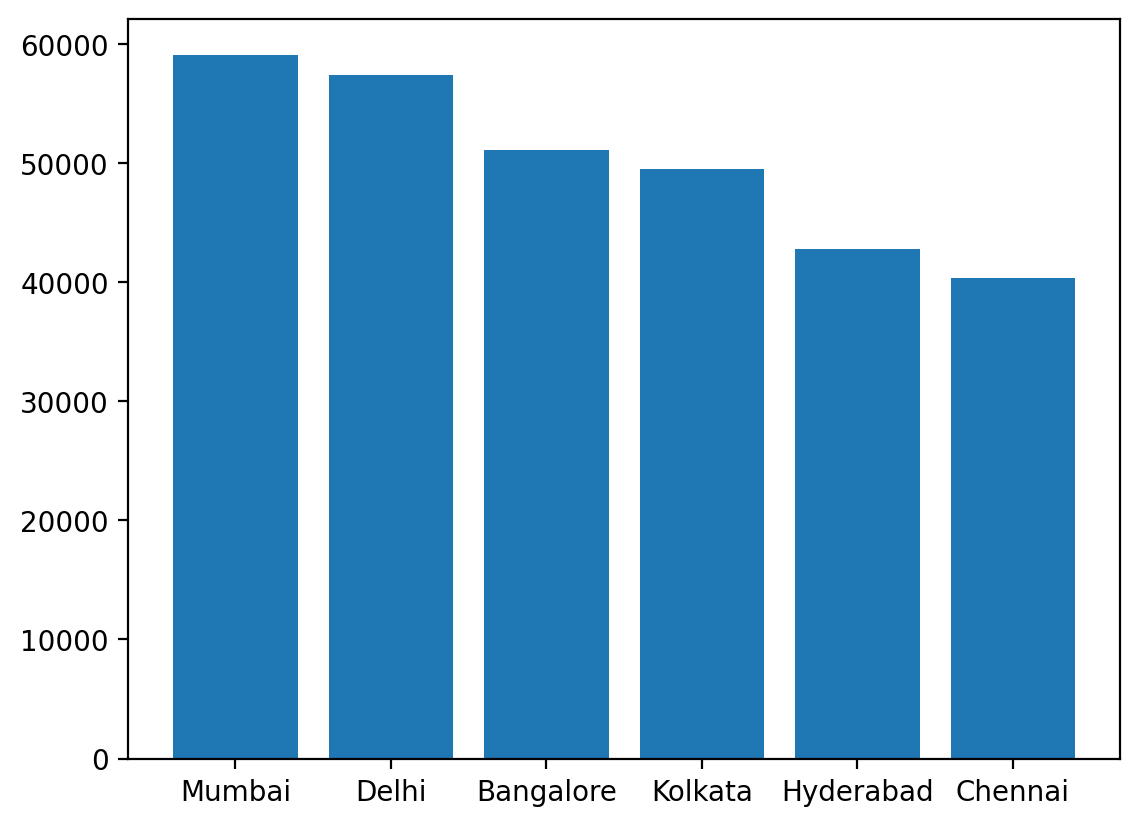

In [24]:
plt.bar(destination['destination_city'],destination['Counts'])
plt.show()

Visualized the pricing data in boxplot to see the price distribution for each source city and destination city:

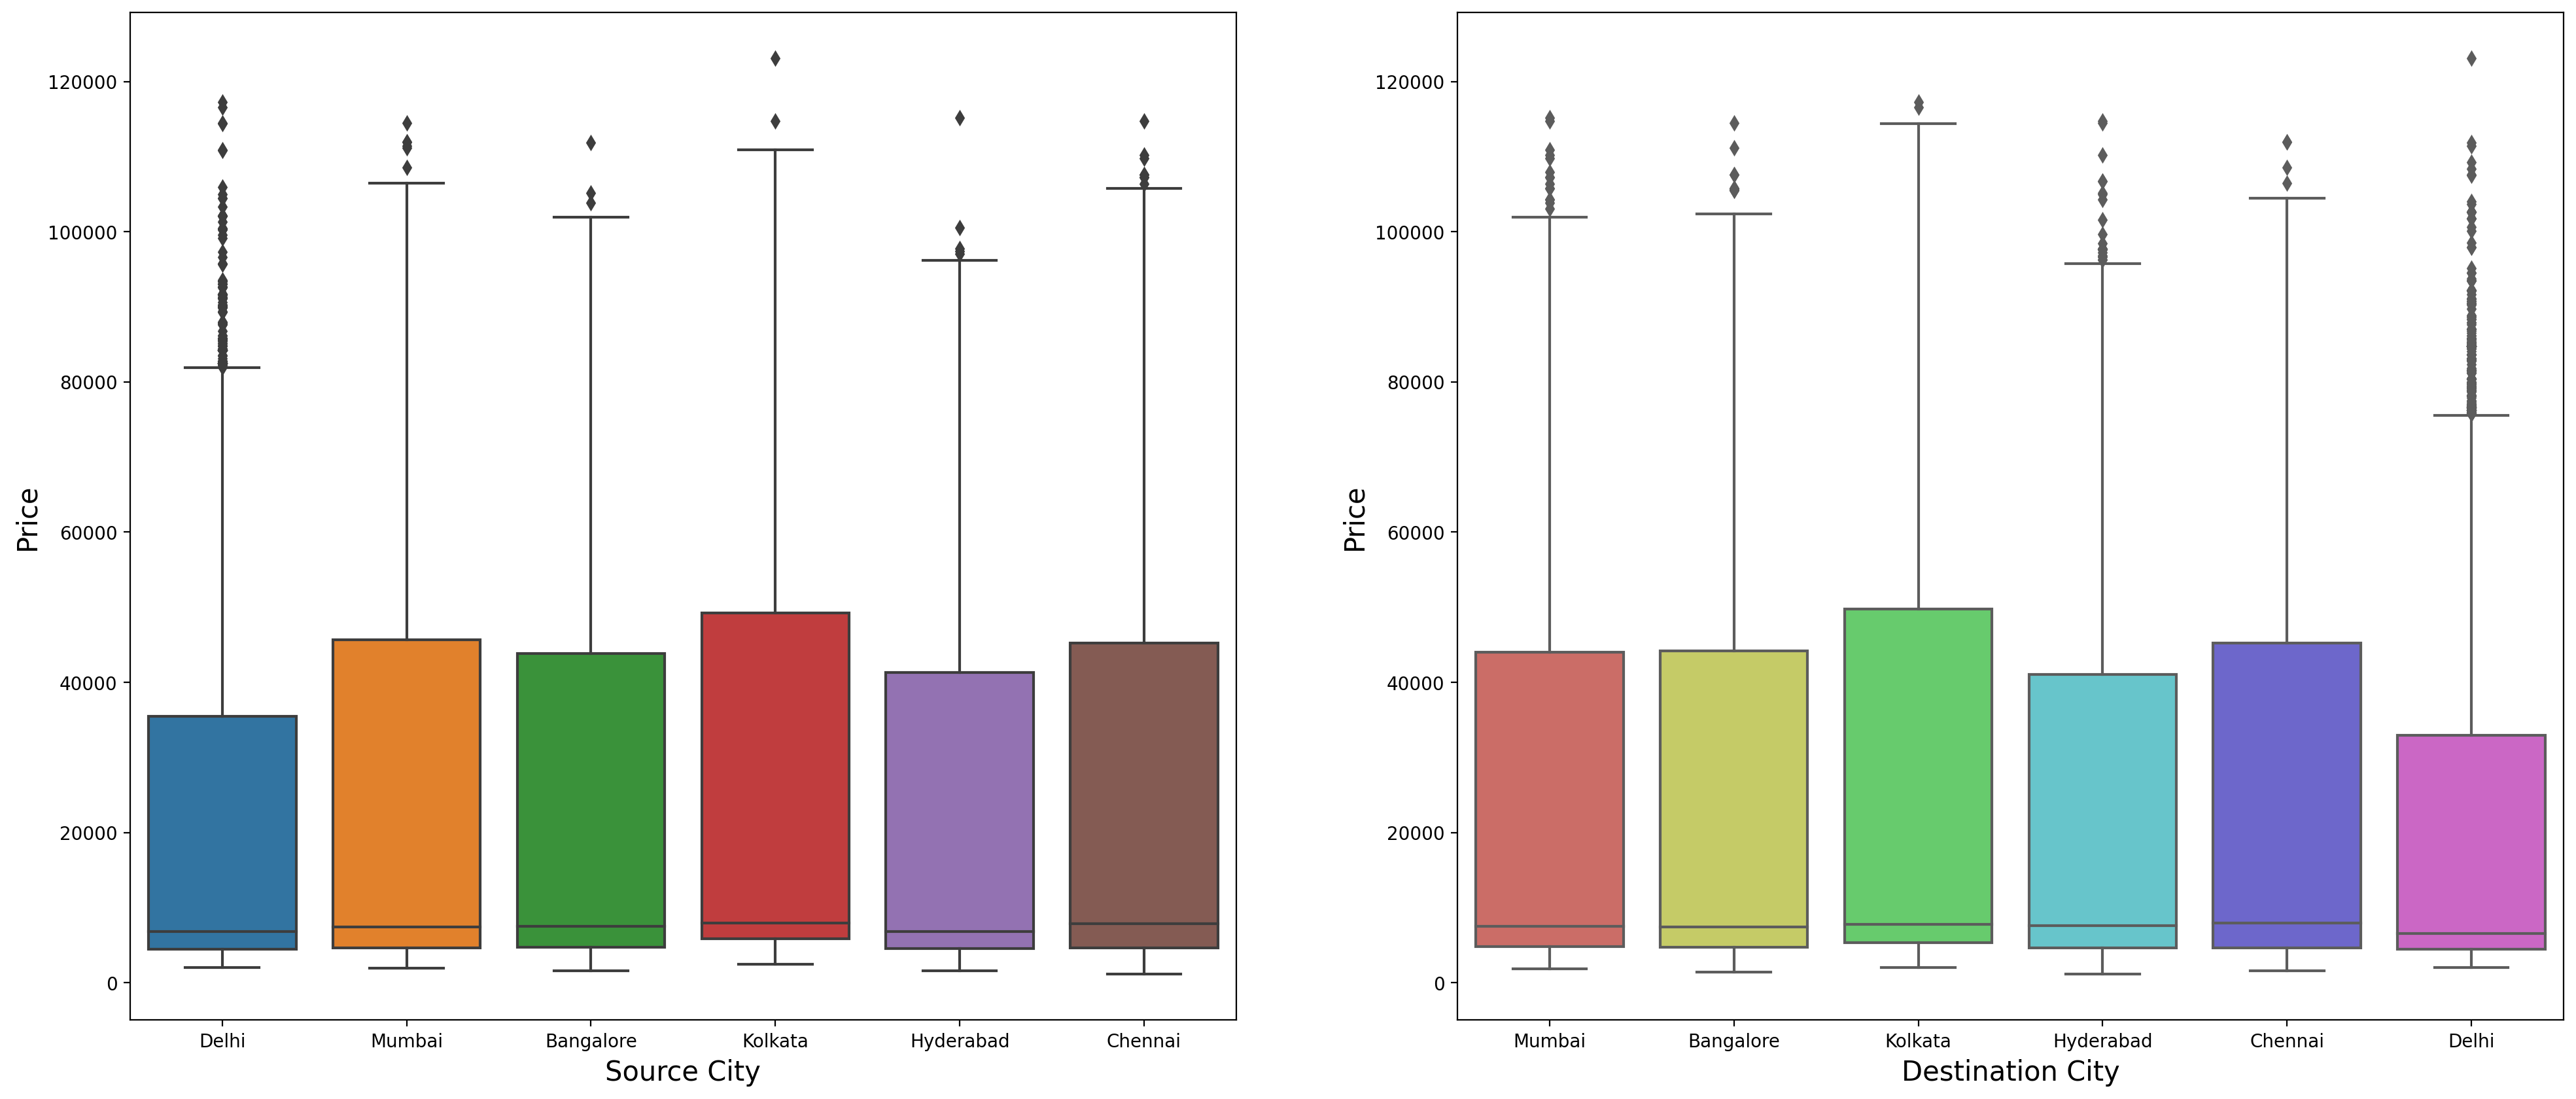

In [25]:
#To check price distribution based on source and destination city
plt.figure(figsize =(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='source_city', y='price', data = df)
plt.xlabel("Source City", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='destination_city', y='price', data=df, palette='hls')
plt.ylabel("Price", fontsize=15)
plt.xlabel("Destination City", fontsize =15)
plt.show()

Generated a line plot that illustrates the relationship between the number of days left before departure and the price of flight:

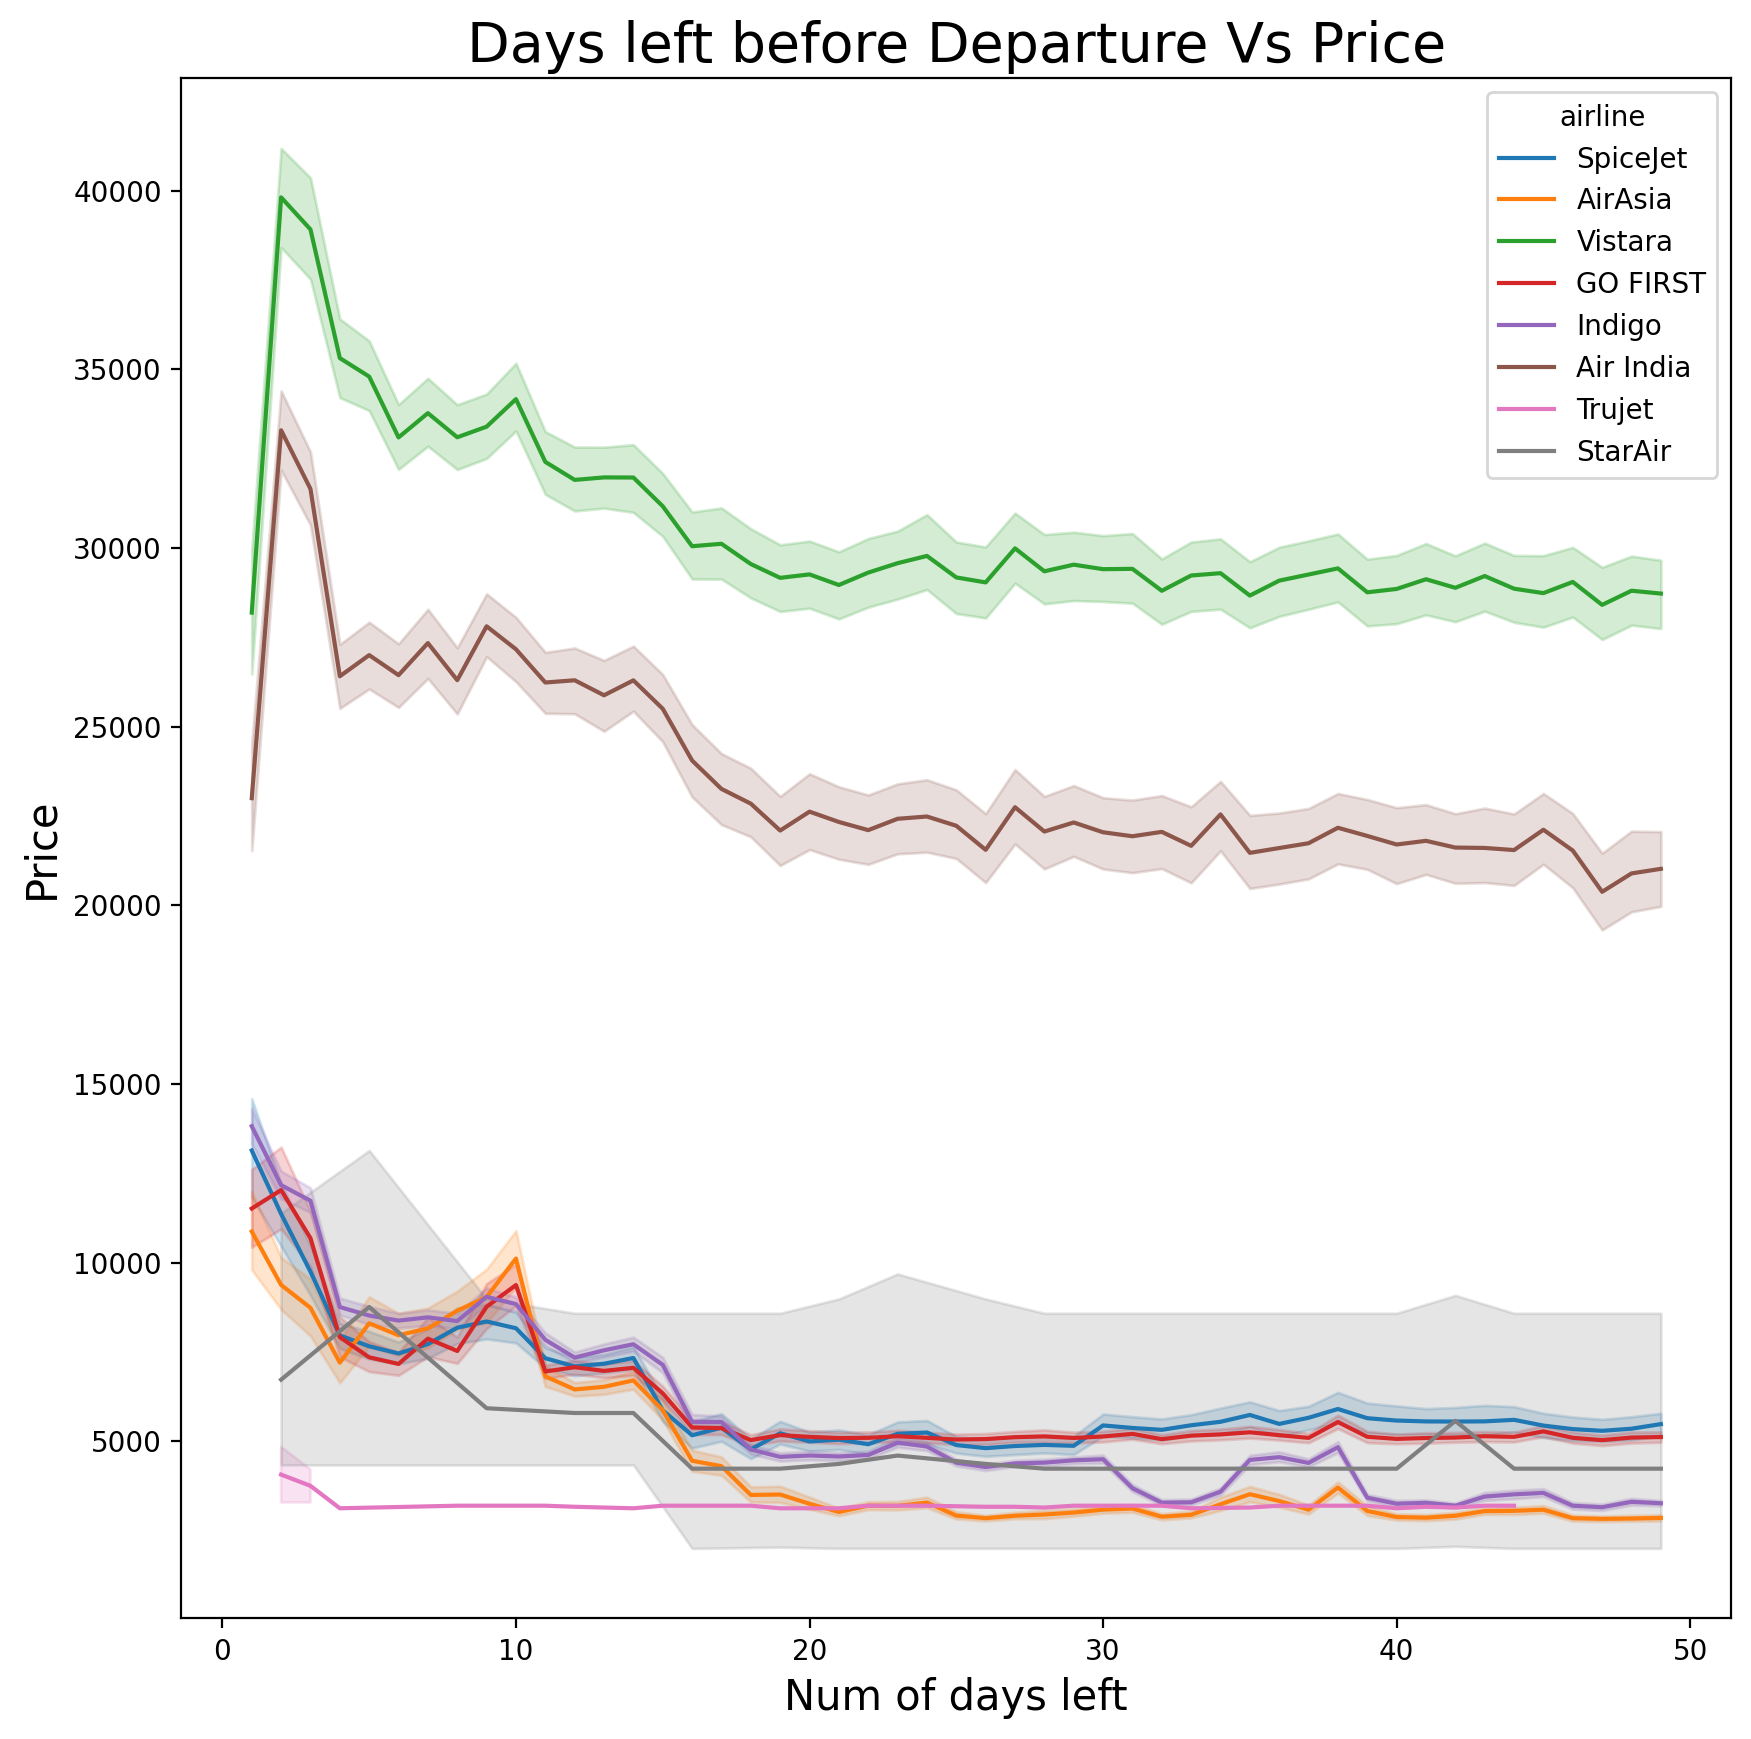

In [26]:
plt.figure(figsize=(10,10))
plt.xlabel("Num of days left", fontsize=15)
plt.ylabel("Price", fontsize=15)
sns.lineplot(data=df, x='days_left', y='price', hue='airline',color='blue')
plt.title("Days left before Departure Vs Price", fontsize=20)
plt.show()

Defined two lists, 'categorical_features' and 'numerical_features', and combined them into a single list called 'features'. Set the target variable to "price":

In [27]:
# Exclude ch_code, num_code, time_taken, departure_time, arrival_time, stop

categorical_features = [
    "date",
    "airline",
    "flight",
    "source_city",
    "destination_city",
    "stops",
    "via",
    "class"
]

numerical_features = [
    "days_left",
    "departure_time_hr",
    "departure_time_min",
    "arrival_time_hr",
    "arrival_time_min",
    "duration",
]

features = categorical_features + numerical_features
target = "price"

Generated a correlation heatmap to analyze the relationships between the numerical features and the target variable, "price":

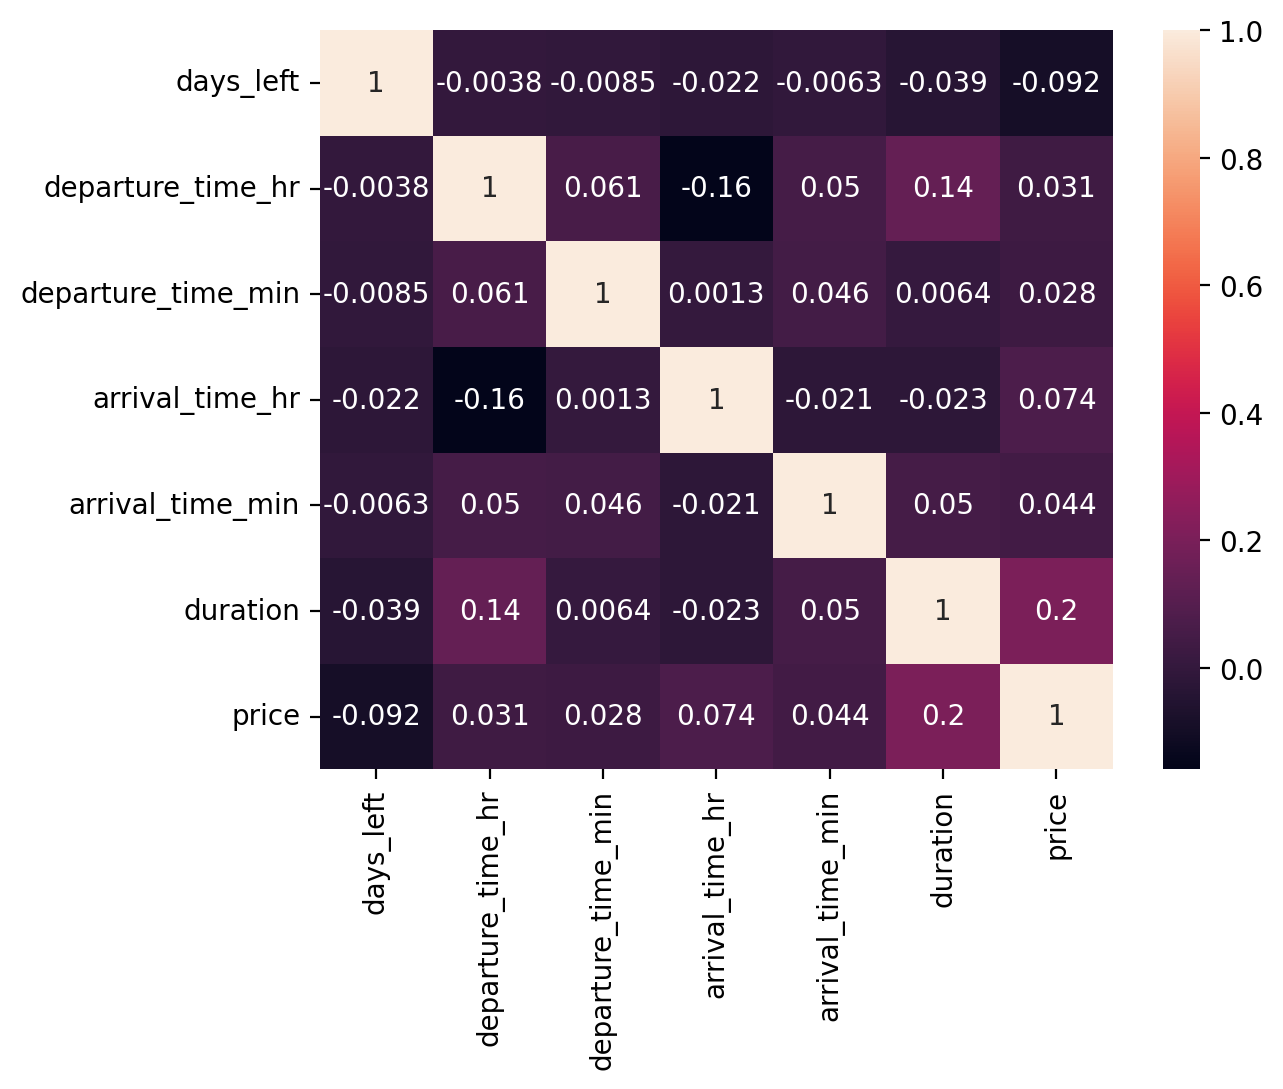

In [28]:
sns.heatmap(df[numerical_features + [target]].corr(), annot=True)
plt.show()

# 5. Modelling

We calculated various regression evaluation metrics based on the predicted and true target values (y_pred and y_test):

In [34]:
def reg_scores(y_test, y_pred):
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

def evaluate(model):
    y_pred_val = model.predict(X_val_scaled)
    y_pred_test = model.predict(X_test_scaled)

    val_mse = mean_squared_error(y_val_scaled, y_pred_val)
    test_mse = mean_squared_error(y_test_scaled, y_pred_test)

    y_pred_test_actual = np.expm1(model.predict(X_test_scaled))
    actual_scores = reg_scores(y_test, y_pred_test_actual)

    return val_mse, test_mse, actual_scores

## 5.1 Baselines

Defined a dictionary named models that maps different regression model names to corresponding instances of those models.

In [78]:
models = {
  "Linear Regression": LinearRegression(),
  "Lasso": Lasso(),
  "Ridge": Ridge(),
  "ElasticNet": ElasticNet(),
  "KNN": KNeighborsRegressor(),
  "SVR": LinearSVR(max_iter=2500),
  "Decision Tree": DecisionTreeRegressor()
}

baseline_val_scores = dict()
baseline_test_scores = dict()
baseline_test_scores_actual = dict()

In [79]:
for name, model in models.items():
  model.fit(X_train_scaled, y_train_scaled)

In [80]:
for name, model in models.items():
  val_mse, test_mse, actual_scores = evaluate(model)

  baseline_val_scores[name] = val_mse
  baseline_test_scores[name] = test_mse
  baseline_test_scores_actual[name] = actual_scores

### 5.1.1 Summary

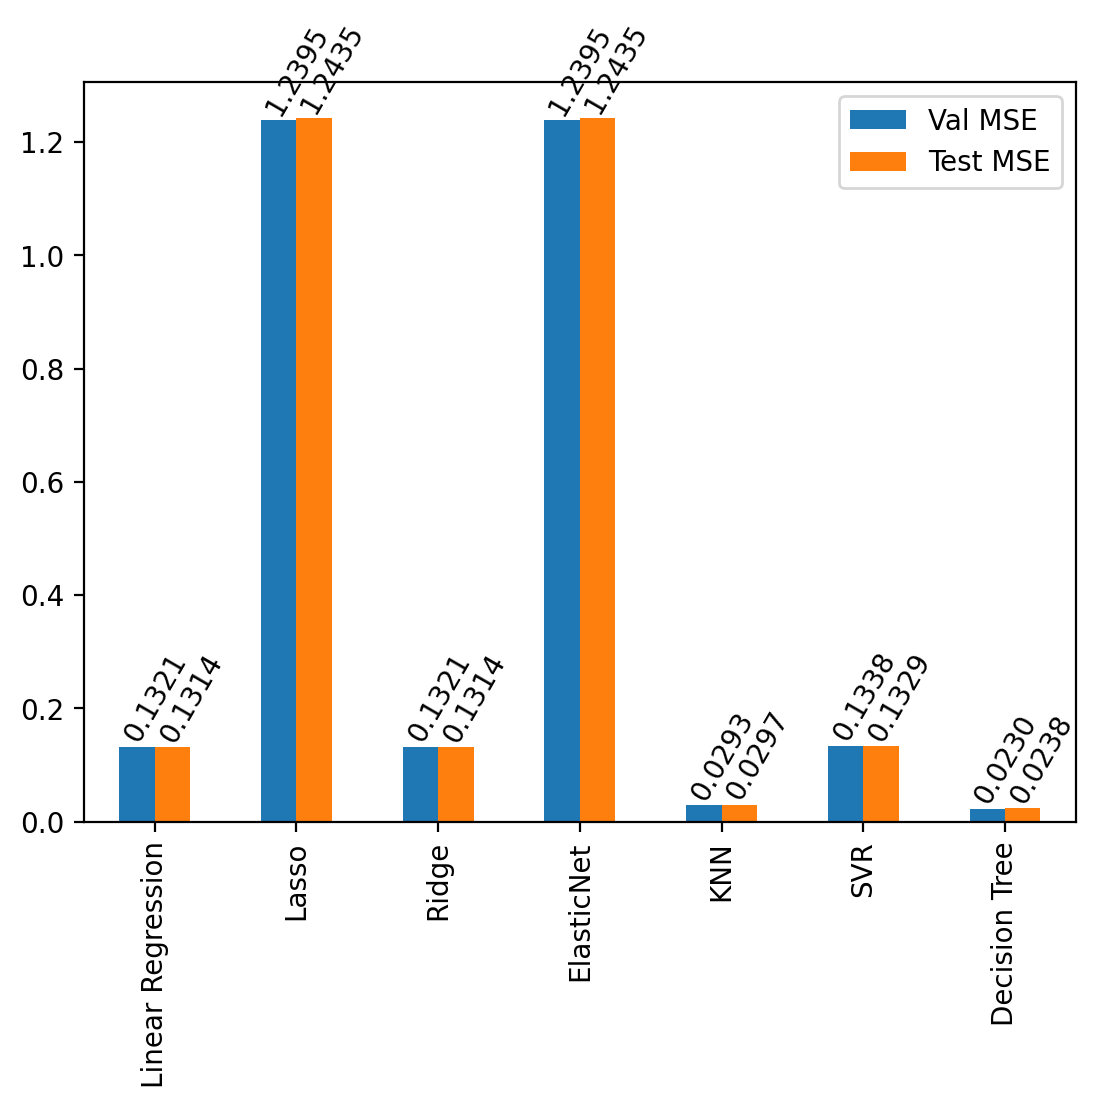

In [81]:
baseline_val_scores_df = pd.DataFrame(
  {
    "Val MSE": baseline_val_scores.values(),
    "Test MSE": baseline_test_scores.values()
  },
  index=baseline_val_scores.keys()
)

ax = baseline_val_scores_df.plot.bar()

for p in ax.patches:
    x = p.get_x()
    y = p.get_height() + 0.01
    label = f"{np.round(p.get_height(), 4):.4f}"

    ax.annotate(label, (x, y), ha='left', rotation=60)

plt.show()

In [ ]:
pd.DataFrame(baseline_test_scores_actual).T.sort_values(by="R2", ascending=False)

## 5.2 Ensemble Learning

In [40]:
ensemble_val_scores = dict()
ensemble_test_scores = dict()
ensemble_test_scores_actual = dict()

### 5.2.1 Random Forest

In [41]:
random_forest = RandomForestRegressor(n_jobs=-1)
random_forest.fit(X_train_scaled, y_train_scaled)

val_mse, test_mse, actual_scores = evaluate(random_forest)

ensemble_val_scores["Random Forest"] = val_mse
ensemble_test_scores["Random Forest"] = test_mse
ensemble_test_scores_actual["Random Forest"] = actual_scores

### 5.2.2 XGBoost

In [42]:
space = {
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "gamma": hp.uniform ("gamma", 1, 9),
    "reg_alpha": hp.quniform("reg_alpha", 40, 180, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree" : hp.uniform("colsample_bytree", 0.5, 1),
    "min_child_weight" : hp.quniform("min_child_weight", 0, 10, 1),
    "n_estimators": hp.quniform("n_estimators", 100, 100000, 1),
    "seed": 0
}

def objective(space):
    model = XGBRegressor(
        early_stopping_rounds=10,
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space["reg_alpha"]),
        reg_lambda=space["reg_lambda"],
        colsample_bytree=space["colsample_bytree"],
        min_child_weight=int(space["min_child_weight"]),
        n_estimators=int(space["n_estimators"])
    )

    model.fit(
        X_train_scaled,
        y_train_scaled,
        eval_set=[(X_val_scaled, y_val_scaled)],
        verbose=False
    )

    y_pred = model.predict(X_val_scaled)
    score = mean_squared_error(y_pred, y_val_scaled)

    return {'loss': score, 'status': STATUS_OK }

In [43]:
trials = Trials()

# best_hyperparams = fmin(
#     fn=objective,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=100,
#     trials=trials
# )

In [44]:
xgb_params = {
    "colsample_bytree": 0.8545834573974018,
    "gamma": 1.0149990564873104,
    "max_depth": 17,
    "min_child_weight": 8.0,
    "n_estimators": 5149,
    "reg_alpha": 40.0,
    "reg_lambda": 0.0008085443779402013
}

xgb = XGBRegressor(
    # **xgb_params,
    n_estimators=10000,
    early_stopping_rounds=25,
    n_jobs=-1
)

xgb.fit(
  X_train_scaled,
  y_train_scaled,
  eval_set=[(X_val_scaled, y_val_scaled)],
  verbose=250
)

val_mse, test_mse, actual_scores = evaluate(xgb)

ensemble_val_scores["XGBoost"] = val_mse
ensemble_test_scores["XGBoost"] = test_mse
ensemble_test_scores_actual["XGBoost"] = actual_scores

[0]	validation_0-rmse:6.23533
[250]	validation_0-rmse:0.15223
[500]	validation_0-rmse:0.13862
[750]	validation_0-rmse:0.13142
[1000]	validation_0-rmse:0.12731
[1250]	validation_0-rmse:0.12455
[1500]	validation_0-rmse:0.12258
[1750]	validation_0-rmse:0.12089
[2000]	validation_0-rmse:0.11985
[2250]	validation_0-rmse:0.11893
[2500]	validation_0-rmse:0.11823
[2750]	validation_0-rmse:0.11744
[3000]	validation_0-rmse:0.11689
[3148]	validation_0-rmse:0.11660


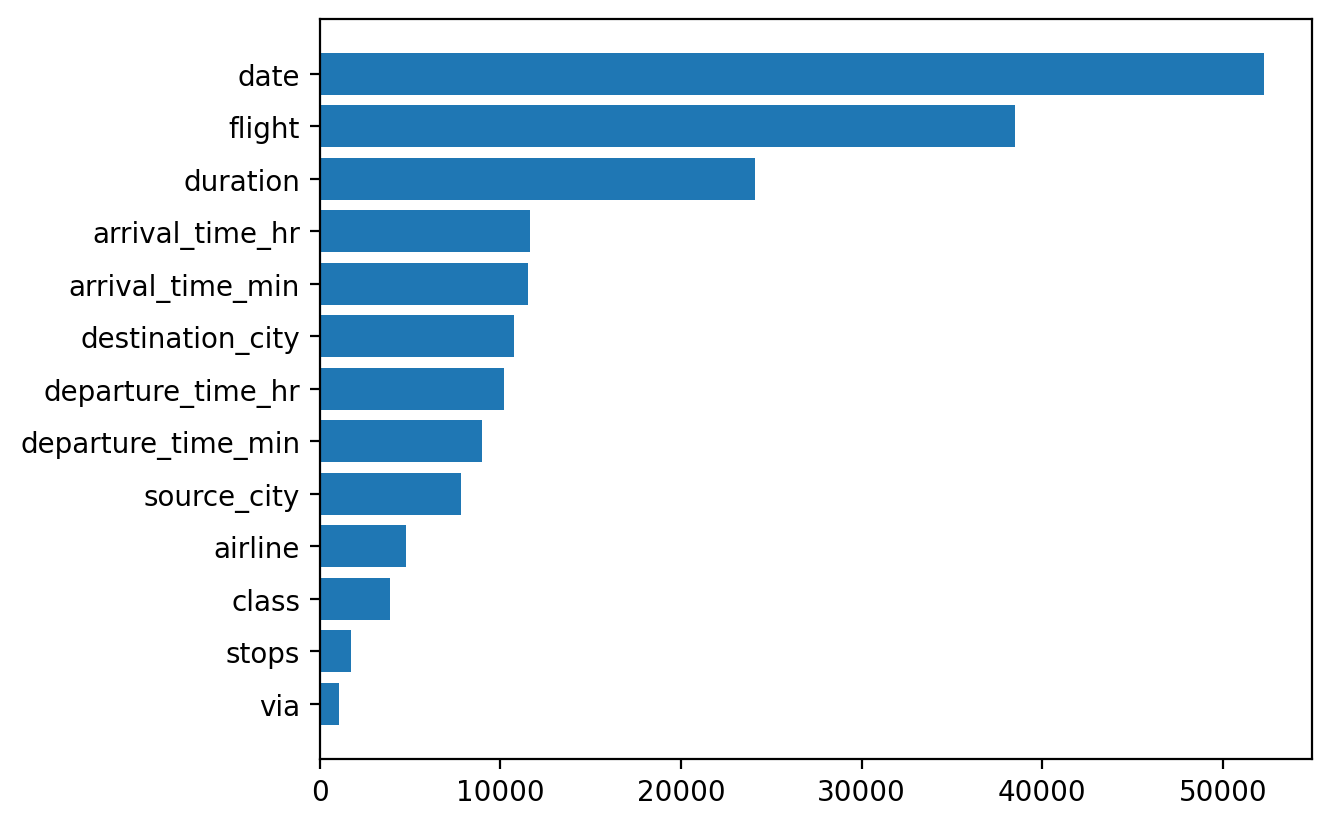

In [45]:
xgb_importance = xgb.get_booster().get_score(importance_type='weight')
xgb_importance_named = dict()

for i, weight in xgb_importance.items():
  xgb_importance_named[features[int(i[1:])]] = weight

xgb_importance_named = dict(sorted(xgb_importance_named.items(), key=lambda item: item[1]))

plt.barh(list(xgb_importance_named.keys()), xgb_importance_named.values())
plt.show()

### 5.2.3 LightGBM

In [46]:
lgb = LGBMRegressor(n_estimators=10000, early_stopping_round=25)
lgb.fit(
  X_train_scaled,
  y_train_scaled,
  eval_set=(X_val_scaled, y_val_scaled),
  callbacks=[log_evaluation(period=500)]
)

val_mse, test_mse, actual_scores = evaluate(lgb)

ensemble_val_scores["LightGBM"] = val_mse
ensemble_test_scores["LightGBM"] = test_mse
ensemble_test_scores_actual["LightGBM"] = actual_scores

[500]	valid_0's l2: 0.0260077
[1000]	valid_0's l2: 0.0212536
[1500]	valid_0's l2: 0.0186844
[2000]	valid_0's l2: 0.0171859
[2500]	valid_0's l2: 0.0161588
[3000]	valid_0's l2: 0.0155169
[3500]	valid_0's l2: 0.0150174
[4000]	valid_0's l2: 0.0145794
[4500]	valid_0's l2: 0.0142277
[5000]	valid_0's l2: 0.0139652
[5500]	valid_0's l2: 0.0137125
[6000]	valid_0's l2: 0.0135196
[6500]	valid_0's l2: 0.013359
[7000]	valid_0's l2: 0.0132102
[7500]	valid_0's l2: 0.0130683
[8000]	valid_0's l2: 0.0129385
[8500]	valid_0's l2: 0.0128227
[9000]	valid_0's l2: 0.0127246
[9500]	valid_0's l2: 0.0126439
[10000]	valid_0's l2: 0.0125478


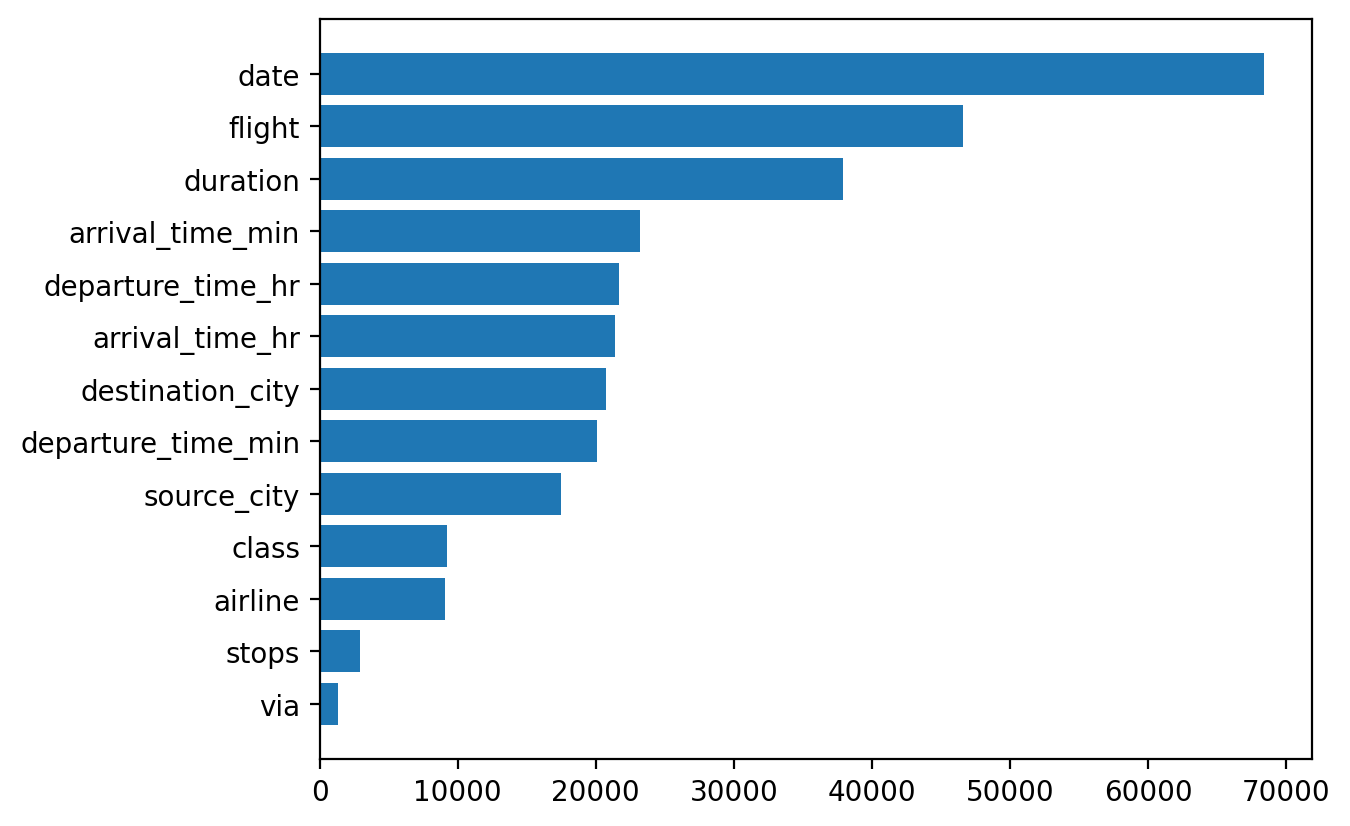

In [47]:
lgb_importance_named = dict()

for i, weight in enumerate(lgb.feature_importances_):
  if weight == 0:
    continue

  lgb_importance_named[features[i]] = weight

lgb_importance_named = dict(sorted(lgb_importance_named.items(), key=lambda item: item[1]))

plt.barh(list(lgb_importance_named.keys()), lgb_importance_named.values())
plt.show()

### 5.2.4 CatBoost

In [48]:
catb = CatBoostRegressor(n_estimators=10000, early_stopping_rounds=25)
catb.fit(
  X_train_scaled,
  y_train_scaled,
  eval_set=(X_val_scaled, y_val_scaled),
  metric_period=500
)

val_mse, test_mse, actual_scores = evaluate(catb)

ensemble_val_scores["CatBoost"] = val_mse
ensemble_test_scores["CatBoost"] = test_mse
ensemble_test_scores_actual["CatBoost"] = actual_scores

Learning rate set to 0.028778


0:	learn: 1.0820556	test: 1.0836628	best: 1.0836628 (0)	total: 236ms	remaining: 39m 21s
500:	learn: 0.2185153	test: 0.2185801	best: 0.2185801 (500)	total: 10.5s	remaining: 3m 18s
1000:	learn: 0.2010222	test: 0.2015092	best: 0.2015092 (1000)	total: 20.1s	remaining: 3m
1500:	learn: 0.1906568	test: 0.1915543	best: 0.1915543 (1500)	total: 30.6s	remaining: 2m 53s
2000:	learn: 0.1836338	test: 0.1849349	best: 0.1849349 (2000)	total: 41s	remaining: 2m 43s
2500:	learn: 0.1780591	test: 0.1798505	best: 0.1798505 (2500)	total: 50.9s	remaining: 2m 32s
3000:	learn: 0.1736138	test: 0.1758900	best: 0.1758900 (3000)	total: 1m	remaining: 2m 22s
3500:	learn: 0.1701095	test: 0.1729418	best: 0.1729418 (3500)	total: 1m 11s	remaining: 2m 12s
4000:	learn: 0.1669272	test: 0.1702216	best: 0.1702216 (4000)	total: 1m 21s	remaining: 2m 2s
4500:	learn: 0.1639848	test: 0.1677256	best: 0.1677256 (4500)	total: 1m 32s	remaining: 1m 52s
5000:	learn: 0.1613138	test: 0.1654519	best: 0.1654519 (5000)	total: 1m 42s	remainin

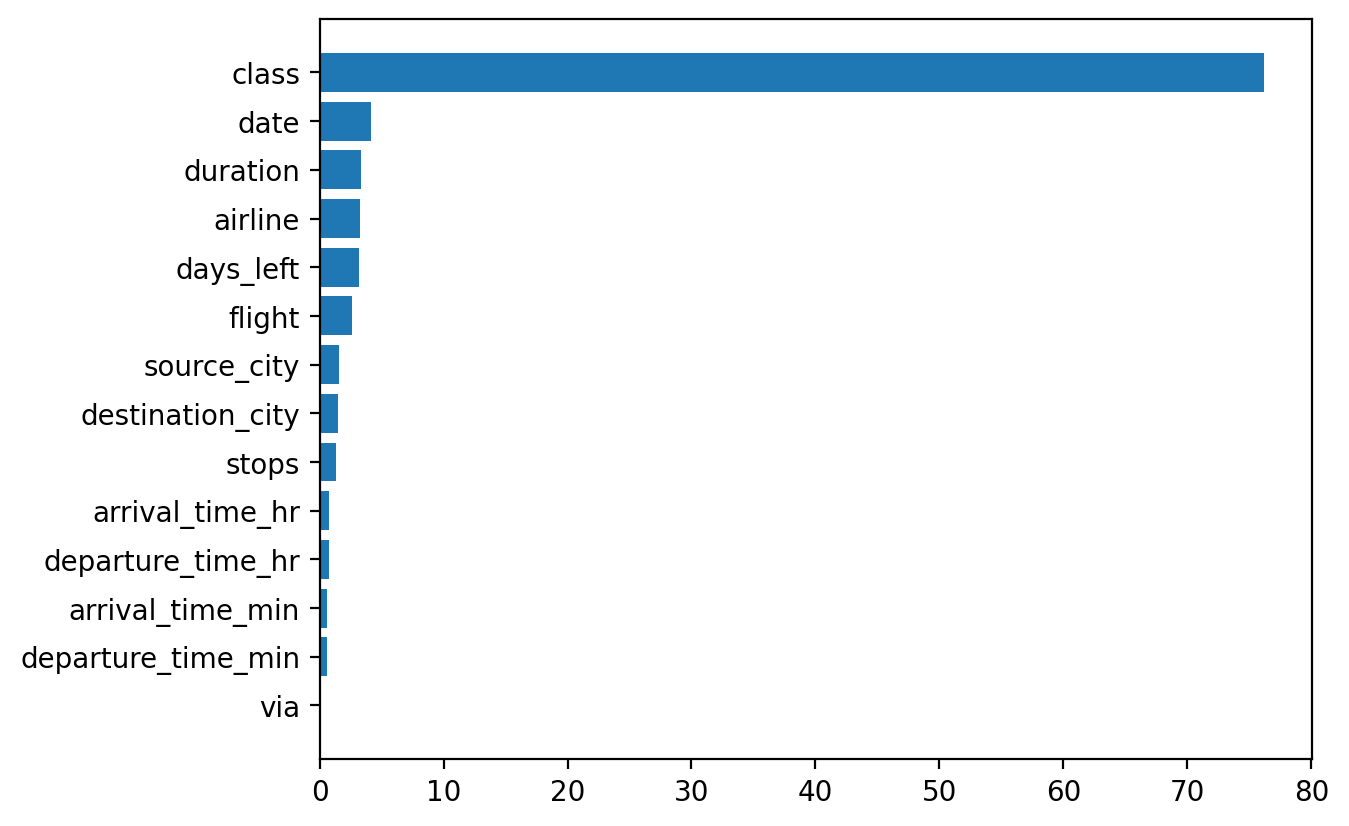

In [49]:
catb_importance_named = dict()

for i, weight in enumerate(catb.feature_importances_):
  catb_importance_named[features[i]] = weight

catb_importance_named = dict(sorted(catb_importance_named.items(), key=lambda item: item[1]))

plt.barh(list(catb_importance_named.keys()), catb_importance_named.values())
plt.show()

### 5.2.5 Summary

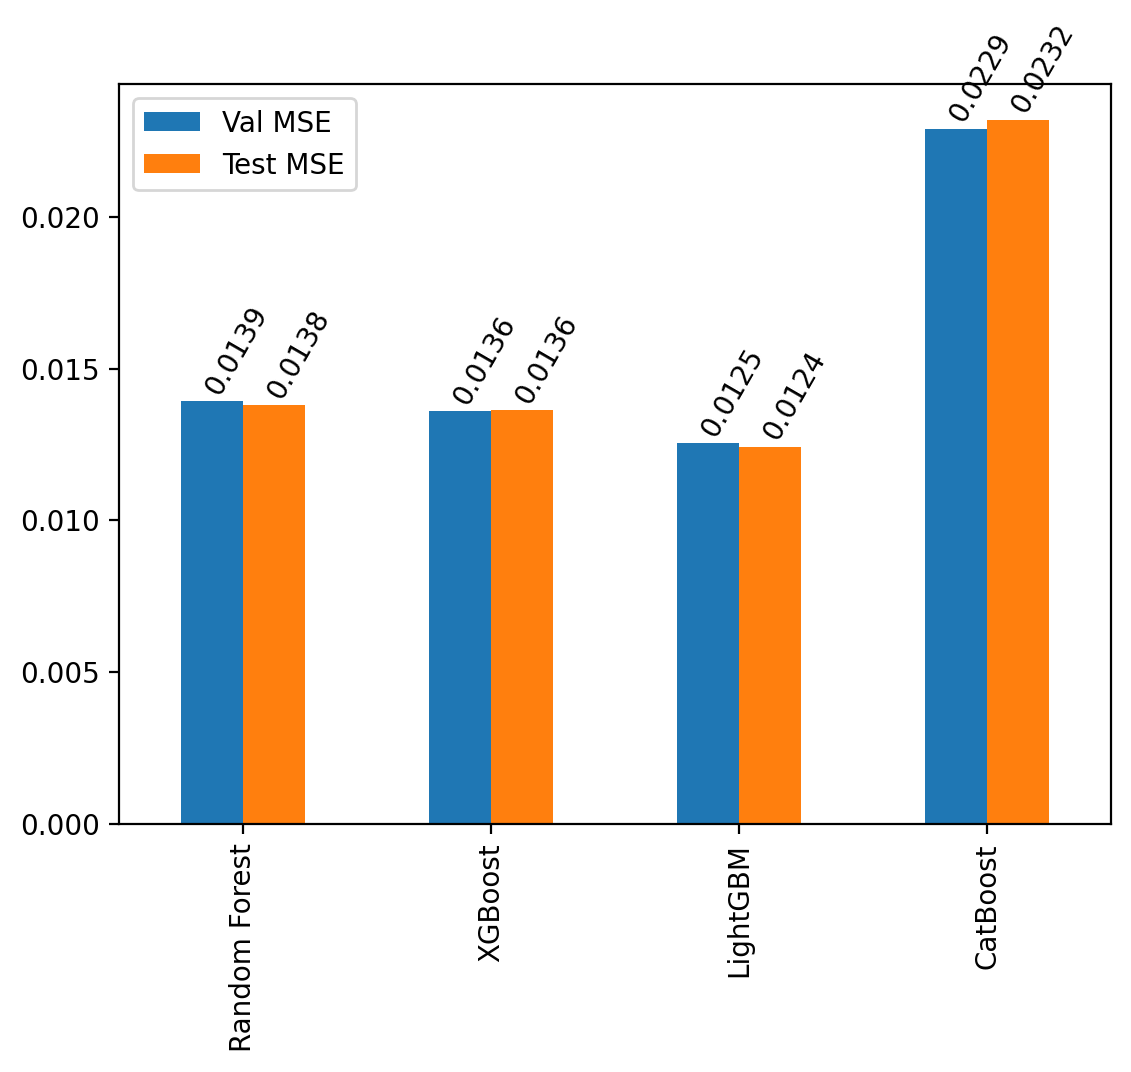

In [50]:
ensemble_val_scores_df = pd.DataFrame(
  {
    "Val MSE": ensemble_val_scores.values(),
    "Test MSE": ensemble_test_scores.values()
  },
  index=ensemble_val_scores.keys()
)

ax = ensemble_val_scores_df.plot.bar()

for p in ax.patches:
    x = p.get_x() + 0.075
    y = p.get_height() + 0.00025
    label = f"{np.round(p.get_height(), 4):.4f}"

    ax.annotate(label, (x, y), ha='left', rotation=60)

plt.show()

In [51]:
pd.DataFrame(ensemble_test_scores_actual).T.sort_values(by="R2", ascending=False)

,MAE,MAPE,MSE,RMSE,R2
Random Forest,898.666348,0.054292,5.637797e+06,2374.404646,0.989109
LightGBM,1117.195805,0.063868,5.675863e+06,2382.407018,0.989035
XGBoost,1352.400520,0.070611,7.879872e+06,2807.110918,0.984778
CatBoost,1673.417480,0.100385,1.036040e+07,3218.758176,0.979986


## 5.3 Neural Networks

In [86]:
nn_val_scores = dict()
nn_test_scores = dict()
nn_test_scores_actual = dict()

### 5.3.1 MLP 256

In [87]:
mlp_256 = Sequential()

mlp_256.add(Input(shape=(14,)))

mlp_256.add(Dense(256, activation="relu"))
mlp_256.add(Dropout(0.2))

mlp_256.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_256.compile(loss="mean_squared_error", optimizer=opt)

In [107]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_256_hist = mlp_256.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# mlp_256.save("artifacts/mlp_256.h5")

# with open('logs/mlp_256.json', "w") as f:
#     f.write(json.dumps(mlp_256_hist.history))

In [89]:
mlp_256 = keras.models.load_model("artifacts/mlp_256.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_256)

nn_val_scores["MLP 256"] = val_mse
nn_test_scores["MLP 256"] = test_mse
nn_test_scores_actual["MLP 256"] = actual_scores

2346/2346 [==============================] - 2s 1ms/step


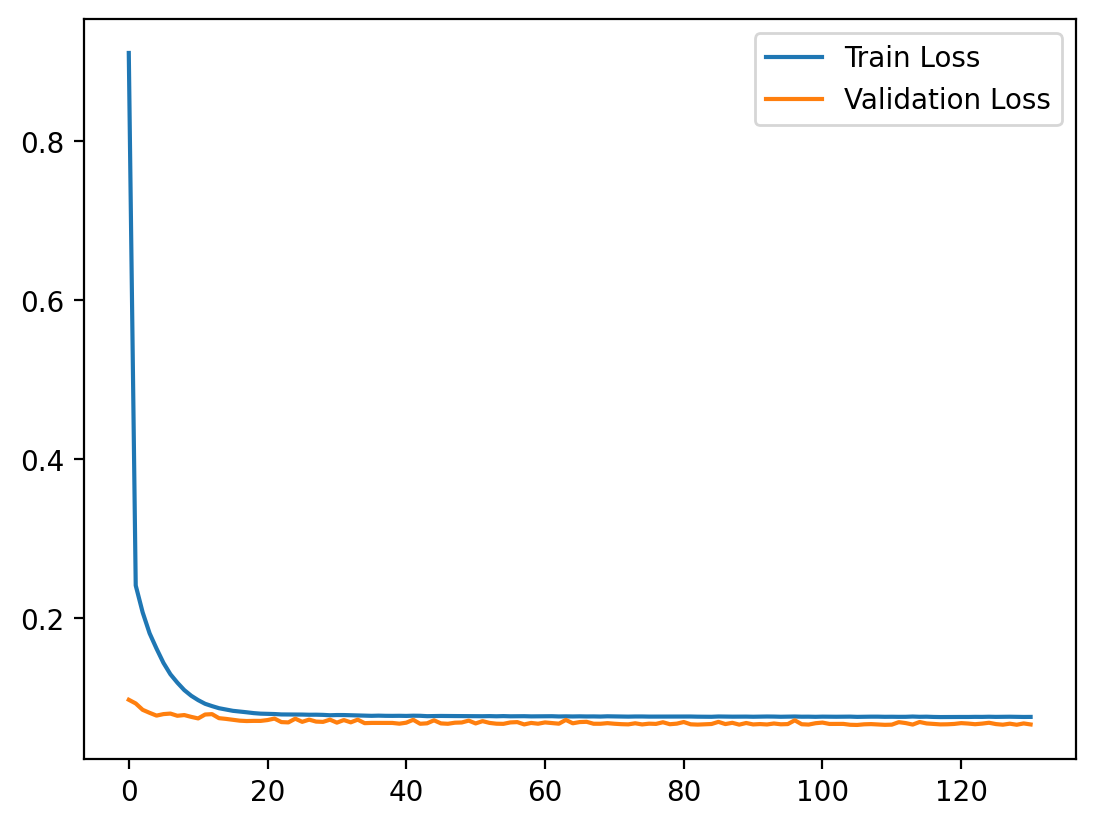

In [90]:
with open("logs/mlp_256.json", "r") as f:
  mlp_256_hist = json.loads(f.read())

plt.plot(mlp_256_hist["loss"])
plt.plot(mlp_256_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

### 5.3.2 MLP 128x64x32

In [101]:
mlp_128_64_32 = Sequential()

mlp_128_64_32.add(Input(shape=(14,)))

mlp_128_64_32.add(Dense(128, activation="relu"))
mlp_128_64_32.add(Dropout(0.2))

mlp_128_64_32.add(Dense(64, activation="relu"))
mlp_128_64_32.add(Dropout(0.2))

mlp_128_64_32.add(Dense(32, activation="relu"))
mlp_128_64_32.add(Dropout(0.2))

mlp_128_64_32.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_128_64_32.compile(loss="mean_squared_error", optimizer=opt)

In [106]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_128_64_32_hist = mlp_128_64_32.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# mlp_128_64_32.save("artifacts/mlp_128_64_32.h5")

# with open('logs/mlp_128_64_32.json', "w") as f:
#     f.write(json.dumps(mlp_128_64_32_hist.history))

In [103]:
mlp_128_64_32 = keras.models.load_model("artifacts/mlp_128_64_32.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_128_64_32)

nn_val_scores["MLP 128x64x32"] = val_mse
nn_test_scores["MLP 128x64x32"] = test_mse
nn_test_scores_actual["MLP 128x64x32"] = actual_scores

2346/2346 [==============================] - 2s 1ms/step


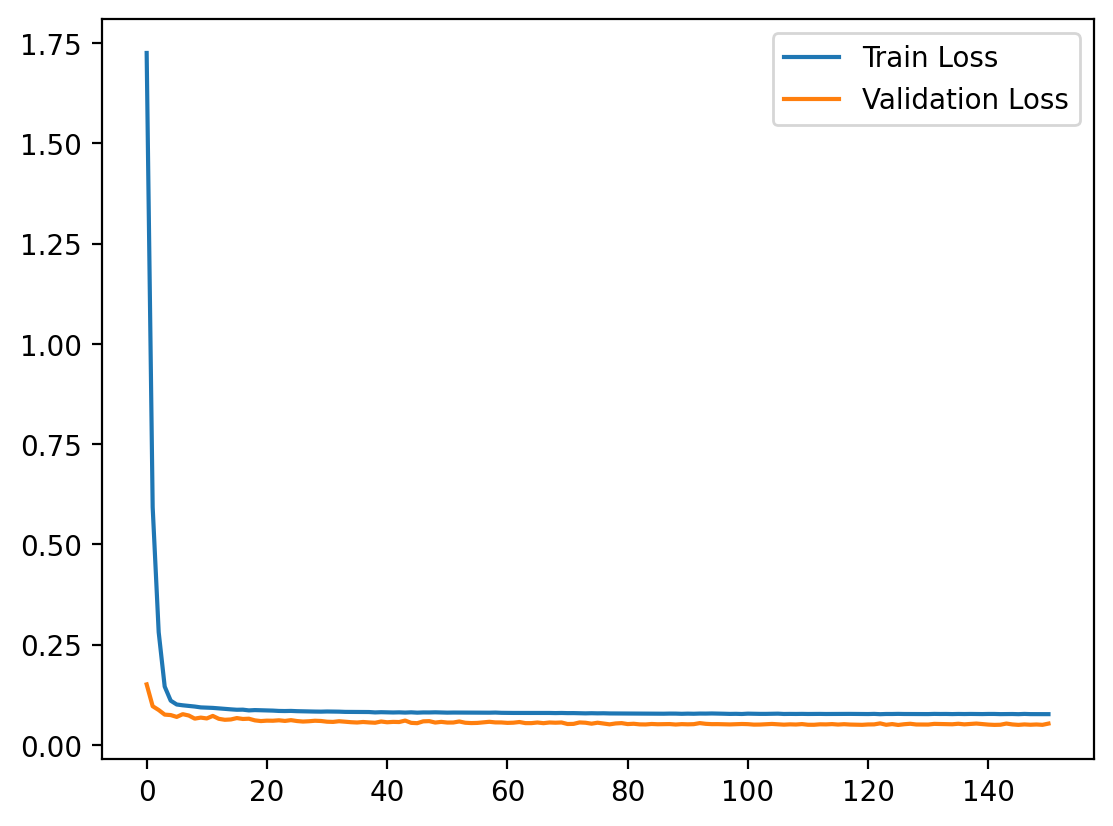

In [104]:
with open("logs/mlp_128_64_32.json", "r") as f:
  mlp_128_64_32_hist = json.loads(f.read())

plt.plot(mlp_128_64_32_hist["loss"])
plt.plot(mlp_128_64_32_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

### 5.3.3 MLP 256x128x64

In [108]:
mlp_256_128_64 = Sequential()

mlp_256_128_64.add(Input(shape=(14,)))

mlp_256_128_64.add(Dense(256, activation="relu"))
mlp_256_128_64.add(Dropout(0.2))

mlp_256_128_64.add(Dense(128, activation="relu"))
mlp_256_128_64.add(Dropout(0.2))

mlp_256_128_64.add(Dense(64, activation="relu"))
mlp_256_128_64.add(Dropout(0.2))

mlp_256_128_64.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_256_128_64.compile(loss="mean_squared_error", optimizer=opt)

In [110]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_256_128_64_hist = mlp_256_128_64.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# mlp_256_128_64.save("artifacts/mlp_256_128_64.h5")

# with open('logs/mlp_256_128_64.json', "w") as f:
#     f.write(json.dumps(mlp_256_128_64_hist.history))

In [111]:
mlp_256_128_64 = keras.models.load_model("artifacts/mlp_256_128_64.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_256_128_64)

nn_val_scores["MLP 256x128x64"] = val_mse
nn_test_scores["MLP 256x128x64"] = test_mse
nn_test_scores_actual["MLP 256x128x64"] = actual_scores

2346/2346 [==============================] - 3s 1ms/step


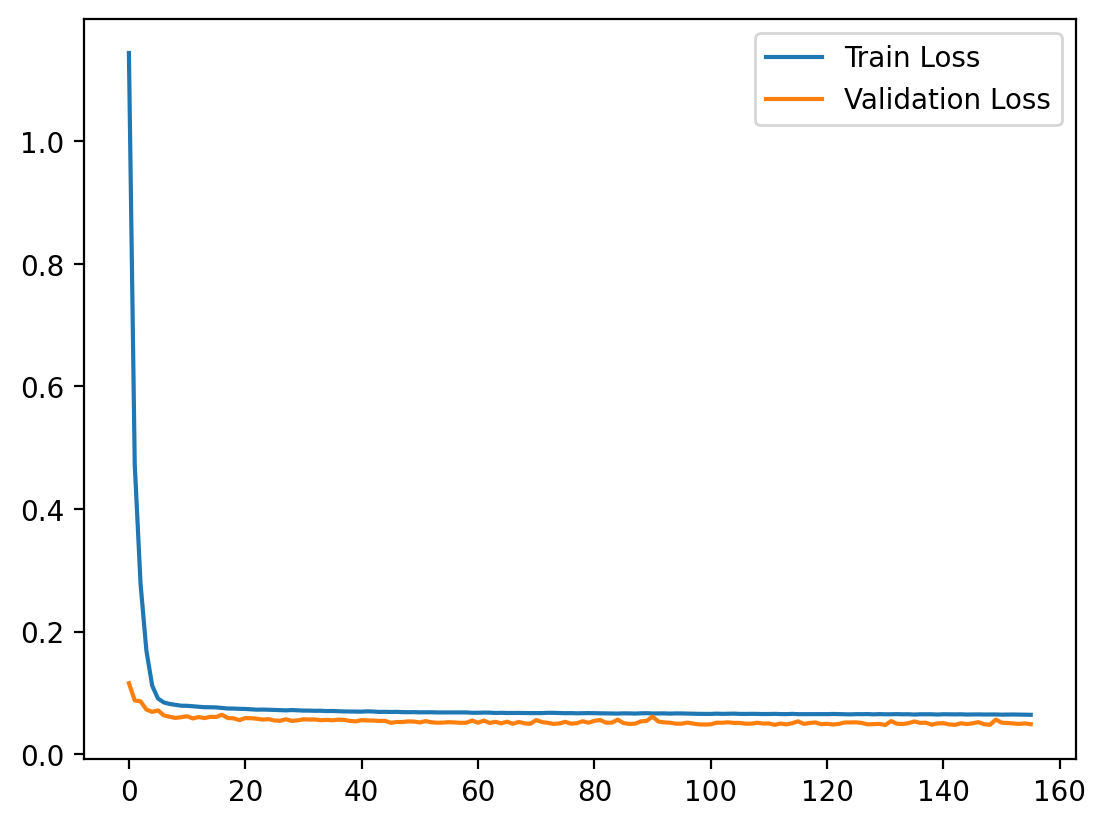

In [112]:
with open("logs/mlp_256_128_64.json", "r") as f:
  mlp_256_128_64_hist = json.loads(f.read())

plt.plot(mlp_256_128_64_hist["loss"])
plt.plot(mlp_256_128_64_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

### 5.3.4 MLP 1024x512x256

In [120]:
mlp_1024_512_256 = Sequential()

mlp_1024_512_256.add(Input(shape=(14,)))

mlp_1024_512_256.add(Dense(1024, activation="relu"))
mlp_1024_512_256.add(Dropout(0.2))

mlp_1024_512_256.add(Dense(512, activation="relu"))
mlp_1024_512_256.add(Dropout(0.2))

mlp_1024_512_256.add(Dense(256, activation="relu"))
mlp_1024_512_256.add(Dropout(0.2))

mlp_1024_512_256.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_1024_512_256.compile(loss="mean_squared_error", optimizer=opt)

In [122]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_1024_512_256_hist = mlp_1024_512_256.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# mlp_1024_512_256.save("artifacts/mlp_1024_512_256.h5")

# with open('logs/mlp_1024_512_256.json', "w") as f:
#     f.write(json.dumps(mlp_1024_512_256_hist.history))

In [123]:
mlp_1024_512_256 = keras.models.load_model("artifacts/mlp_1024_512_256.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_1024_512_256)

nn_val_scores["MLP 1024x512x256"] = val_mse
nn_test_scores["MLP 1024x512x256"] = test_mse
nn_test_scores_actual["MLP 1024x512x256"] = actual_scores

2346/2346 [==============================] - 6s 3ms/step


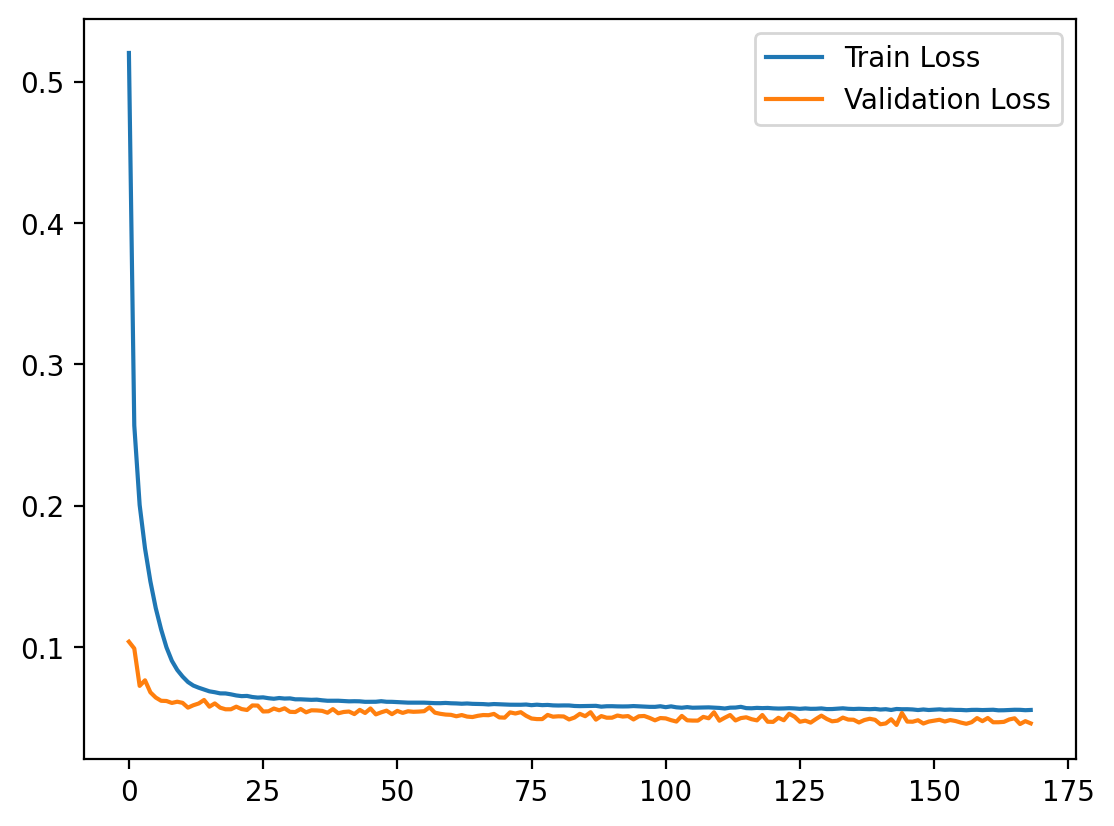

In [124]:
with open("logs/mlp_1024_512_256.json", "r") as f:
  mlp_1024_512_256_hist = json.loads(f.read())

plt.plot(mlp_1024_512_256_hist["loss"])
plt.plot(mlp_1024_512_256_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

### 5.3.5 Summary

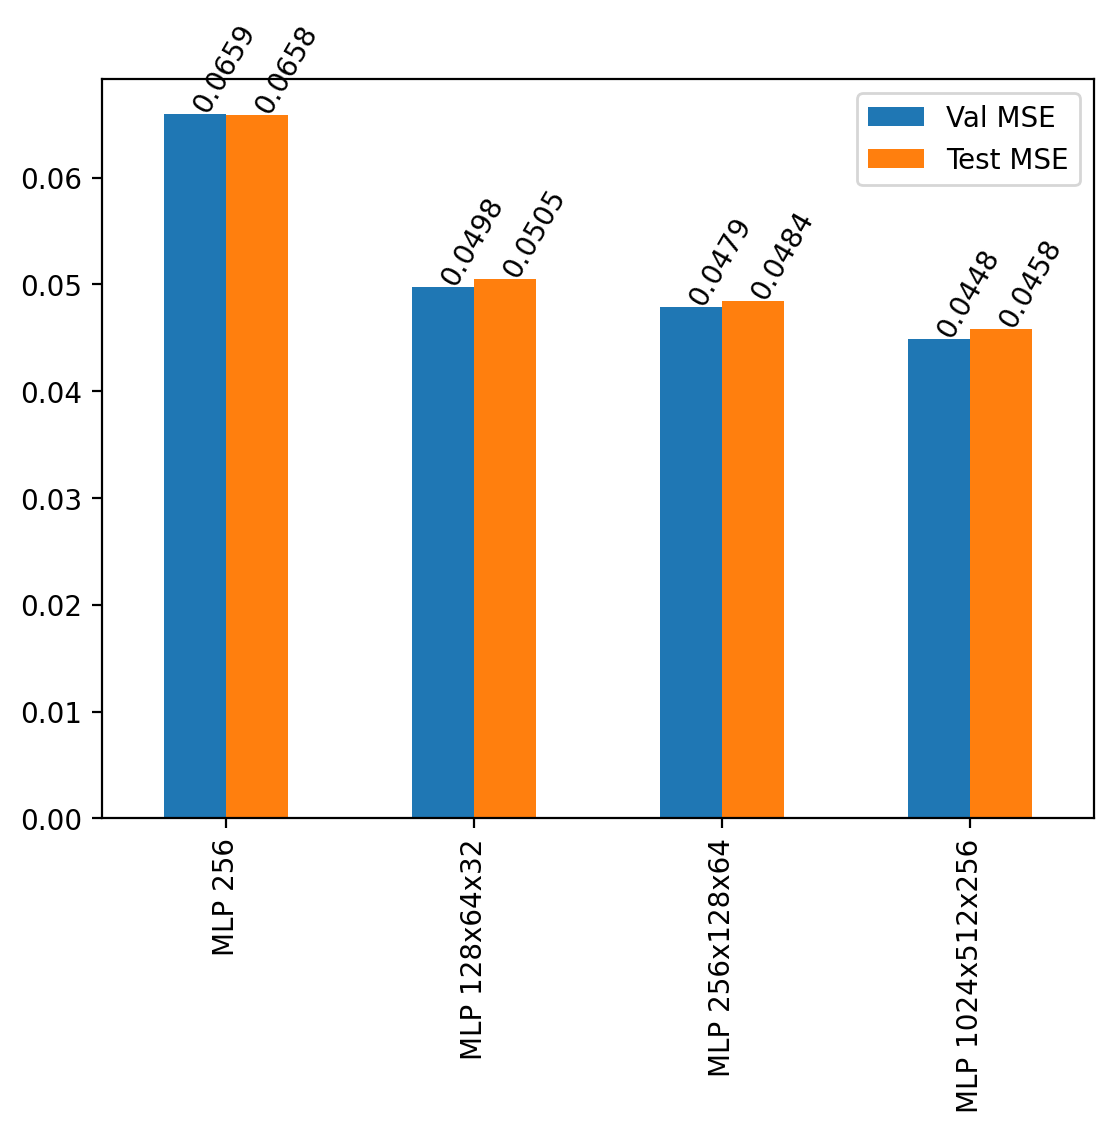

In [125]:
nn_val_scores_df = pd.DataFrame(
  {
    "Val MSE": nn_val_scores.values(),
    "Test MSE": nn_test_scores.values()
  },
  index=nn_val_scores.keys()
)

ax = nn_val_scores_df.plot.bar()

for p in ax.patches:
    x = p.get_x() + 0.1
    y = p.get_height() + 0.00025
    label = f"{np.round(p.get_height(), 4):.4f}"

    ax.annotate(label, (x, y), ha='left', rotation=60)

plt.show()

In [126]:
pd.DataFrame(nn_test_scores_actual).T.sort_values(by="R2", ascending=False)

,MAE,MAPE,MSE,RMSE,R2
MLP 256x128x64,2635.803243,0.156179,2.295731e+07,4791.378615,0.955651
MLP 128x64x32,2690.842910,0.164255,2.325178e+07,4822.009687,0.955083
MLP 1024x512x256,2654.715521,0.152269,2.415884e+07,4915.164477,0.953330
MLP 256,2976.319992,0.195445,2.652879e+07,5150.610573,0.948752


# 6. Evaluation

In [67]:
y_pred = np.expm1(lgb.predict(X_test_scaled))
y_pred_series = pd.Series(y_pred, index=X_test.index, name="predicted_price")

In [ ]:
predicted_df = pd.concat([X_test, y_test, y_pred_series], axis=1)
predicted_df["deviation"] = predicted_df["predicted_price"] - predicted_df["price"]
predicted_df[categorical_features + numerical_features + ["price", "predicted_price"]].head()

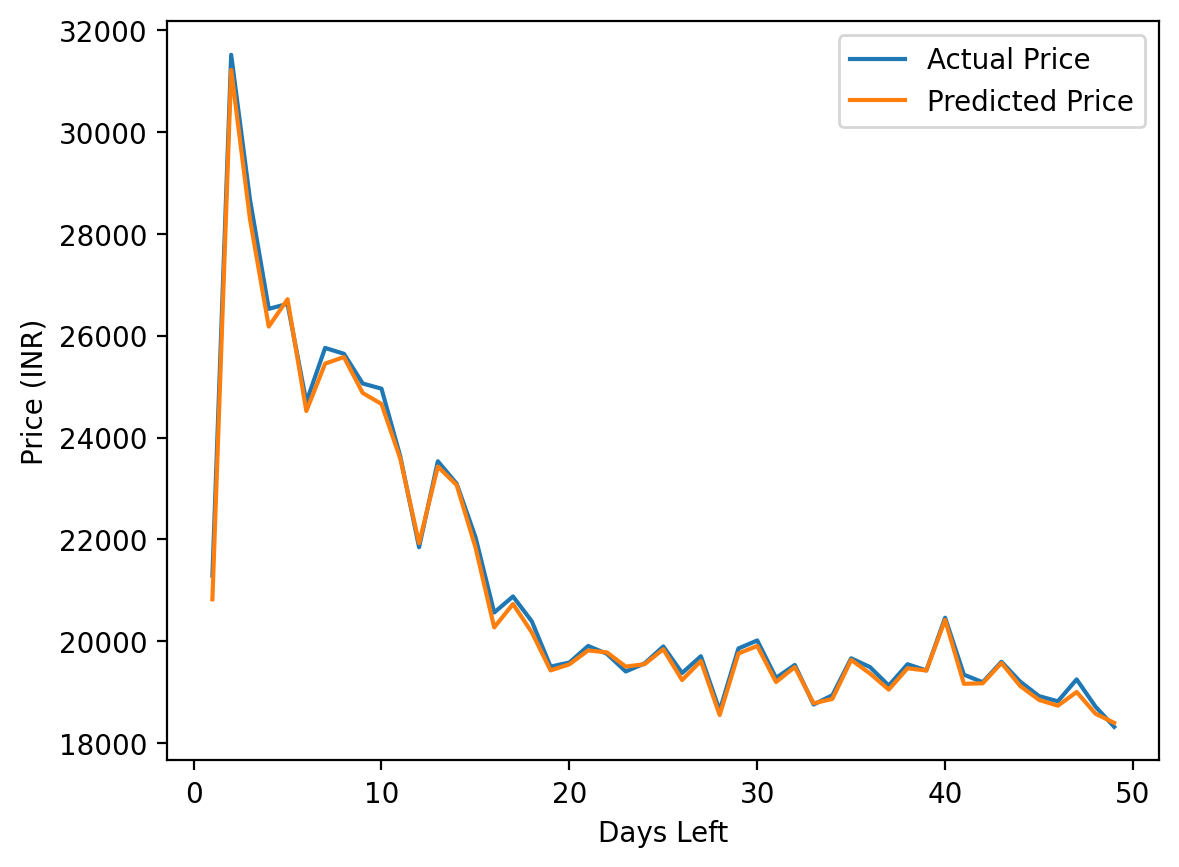

In [69]:
prices_by_days_left = predicted_df[["days_left", "price", "predicted_price"]].groupby("days_left").mean()

plt.plot(prices_by_days_left.index, prices_by_days_left["price"])
plt.plot(prices_by_days_left.index, prices_by_days_left["predicted_price"])

plt.xlabel("Days Left")
plt.ylabel("Price (INR)")
plt.legend(["Actual Price", "Predicted Price"])

plt.show()

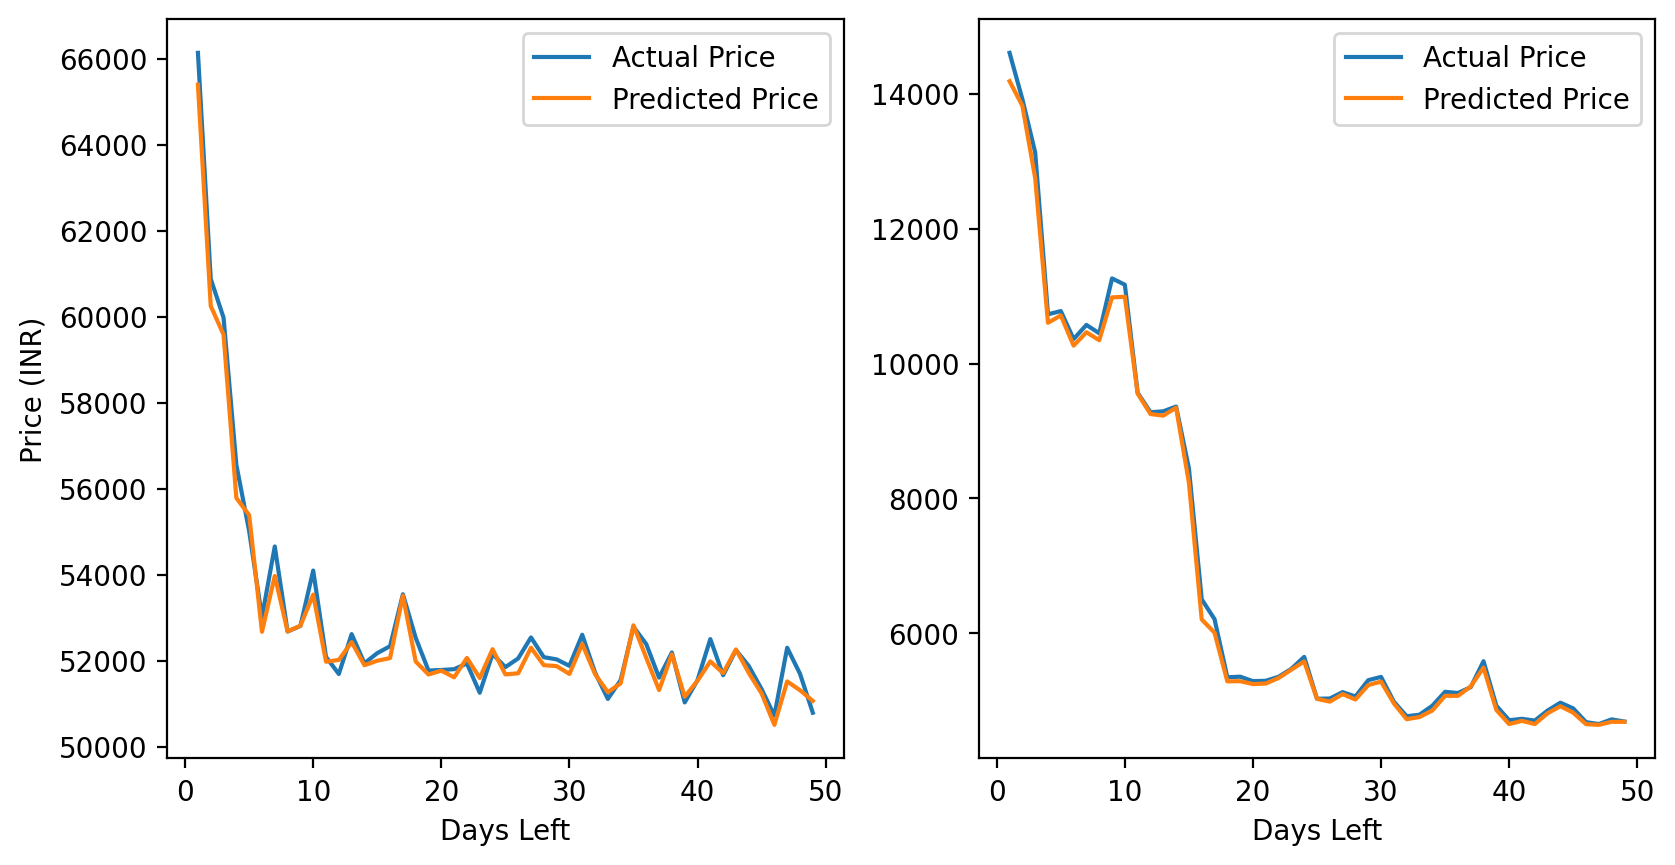

In [70]:
prices_by_days_left = predicted_df[["class", "days_left", "price", "predicted_price"]].groupby(["class", "days_left"]).mean()

plt.figure(figsize=(9.6, 4.8))
plt.subplot(1, 2, 1)
plt.plot(prices_by_days_left.loc["Business"].index, prices_by_days_left.loc["Business"]["price"])
plt.plot(prices_by_days_left.loc["Business"].index, prices_by_days_left.loc["Business"]["predicted_price"])

plt.xlabel("Days Left")
plt.ylabel("Price (INR)")
plt.legend(["Actual Price", "Predicted Price"])

plt.subplot(1, 2, 2)
plt.plot(prices_by_days_left.loc["Economy"].index, prices_by_days_left.loc["Economy"]["price"])
plt.plot(prices_by_days_left.loc["Economy"].index, prices_by_days_left.loc["Economy"]["predicted_price"])

plt.xlabel("Days Left")
plt.legend(["Actual Price", "Predicted Price"])

plt.show()

## 6.1 Error Distribution

In [71]:
predicted_df["deviation"].describe()

count    75066.000000
mean       -99.236278
std       2380.355192
min     -36073.749803
25%       -302.214565
50%         29.310364
75%        423.663405
max      31355.522000
Name: deviation, dtype: float64

In [72]:
print(predicted_df["deviation"].quantile(0.9))
print(predicted_df["deviation"].quantile(0.95))
print(predicted_df["deviation"].quantile(0.99))

1501.1289352828699
2652.9472225582995
5924.976854454828


In [73]:
predicted_df[["class", "deviation"]].groupby("class").describe()

deviation                                                       
             count        mean          std           min          25%   
class                                                                    
Business   23479.0 -152.256317  3906.534154 -36073.749803 -1131.724862  \
Economy    51587.0  -75.105053  1139.063769 -20066.189086  -184.856387   

                                                 
                 50%          75%           max  
class                                            
Business  241.598117  1579.165950  31355.522000  
Economy    16.808363   234.745728  12646.258464

In [74]:
print(predicted_df[["class", "deviation"]].groupby("class").quantile(0.9))
print(predicted_df[["class", "deviation"]].groupby("class").quantile(0.95))
print(predicted_df[["class", "deviation"]].groupby("class").quantile(0.99))

            deviation
class                
Business  3321.801330
Economy    631.636283
            deviation
class                
Business  4775.209714
Economy   1052.172550
            deviation
class                
Business  8769.627962
Economy   2488.170109


# 7. Deployment

# 8. Conclusion